<a href="https://colab.research.google.com/github/bernatsort/Degree_Final_Project/blob/main/TFG_BernatSort_SourceCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Development and evaluation of a new non-invasive and high sampling rate score to assess lung injury for mechanically ventilated patients



## Initial Setup 

### Installs

In [ ]:
# !pip install --upgrade plotly
!pip install plotly

In [ ]:
!pip install pingouin

### Imports

In [ ]:
# Import libraries
import os
import pandas as pd
from pandas.io import gbq
import numpy as np
import seaborn as sns
# import pingouin as pg
from plotnine import *
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import plotly.express as px
# import plotly.graph_objects as go
import warnings
from pathlib import Path
import plotnine as p9
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm
from scipy.stats import jarque_bera
from datetime import datetime, timedelta, date
from scipy.stats import wilcoxon, chi2_contingency

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing MIMIC-IV data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery
from google.cloud.bigquery import magics

### Accessing MIMIC-IV data using BigQuery 

In [ ]:
# Before running any queries using BigQuery, you need to first authenticate yourself
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# Declare the Cloud project ID which will be used throughout this notebook
project_id='sunlit-inn-332208' # my project ID 
# Set up the environment for GCP call for my project: GOOGLE_CLOUD_PROJECT environment variable
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id
# Configure a BigQuery client to use your credentials and project. Instantiates a client for BigQuery Service.
client = bigquery.Client(project=project_id) # Using BigQuery through google-cloud-bigquery

In [ ]:
# Returns a dataframe given query string as input. 
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, configuration={'query':{'useLegacySql': False}}) 

### Mount Google Drive

In [ ]:
# Mount Google Drive to store and load files. 
from google.colab import drive
drive.mount('drive') # mounting Google Drive

Mounted at drive


## Extraction of the entire sofa df


SOFA score is calculated for every hour of the patient's ICU stay. That is why the initial dataset does not contain a row per patient but a row for each patient and its hour relative to admission.

In [ ]:
# Extraction of the entire SOFA df (only ICU patients) 
sofa_table = run_query('''SELECT * FROM `physionet-data.mimic_derived.sofa`''')

In [ ]:
# Dimensionality of the DataFrame: rows and columns
sofa_table.shape

(6358767, 29)

In [ ]:
# Unique patients
sofa_table["stay_id"].nunique()

76519

In [ ]:
sofa_table.columns

Index(['stay_id', 'hr', 'starttime', 'endtime', 'pao2fio2ratio_novent',
       'pao2fio2ratio_vent', 'rate_epinephrine', 'rate_norepinephrine',
       'rate_dopamine', 'rate_dobutamine', 'meanbp_min', 'gcs_min', 'uo_24hr',
       'bilirubin_max', 'creatinine_max', 'platelet_min', 'respiration',
       'coagulation', 'liver', 'cardiovascular', 'cns', 'renal',
       'respiration_24hours', 'coagulation_24hours', 'liver_24hours',
       'cardiovascular_24hours', 'cns_24hours', 'renal_24hours',
       'sofa_24hours'],
      dtype='object')

In [ ]:
# Function that verifies one row per hour of the SOFA table
  # If the condition returns True (n==0), then nothing happens
  # If condition returns False, AssertionError is raised: 'The sofa table has more than one row per (stay_id, hr)'
def test_sofa_one_row_per_hour(dataset, project_id):
    """Verifies one row per hour of the SOFA table"""
    query = f"""
    SELECT
    COUNT(*) AS n
    FROM
    (
        SELECT stay_id, hr FROM {dataset}.sofa GROUP BY 1, 2 HAVING COUNT(*) > 1
    ) s    
    """
    df = gbq.read_gbq(query, project_id=project_id, dialect="standard")
    n = df.loc[0, 'n']
    assert n == 0, 'The sofa table has more than one row per (stay_id, hr)'

In [ ]:
dataset = "physionet-data.mimic_derived"
project_id = 'sunlit-inn-332208'
test_sofa_one_row_per_hour(dataset, project_id) 
# The condition returns True: nothing happens. Therefore, the sofa table has one row per (stay_id, hr)

In [ ]:
# Save sofa_table df as csv to Google Drive
sofa_table.to_csv('sofa_table.csv', index=False)
!cp sofa_table.csv "drive/My Drive/TFG/" 

In [ ]:
# Read csv from Google Drive in Google Colab 
sofa_table = pd.read_csv('drive/My Drive/TFG/sofa_table.csv')
sofa_table.head(2)

## Extraction of the vitalsign df

Vitalsign:
- Many different charttime (the time at which a measurement is charted, is exactly the time of measurement) per patient: as many charttime as have been measured. 
- In order to convert these charttime to hours relative to admission (hr):
  - merge by stay_id (patient) and add the icu_intime column (time at which a patient entered the ICU (1 icu_intime per patient))

In [ ]:
# Extraction of the entire vitalsign table
# Description: the vitalsign table contains aperiodic vital signs documented for patients during their stay.
%%time
vitalsign_table = run_query('''SELECT * FROM `physionet-data.mimic_derived.vitalsign`''')

In [ ]:
# Save vitalsign_table df as csv to Google Drive
vitalsign_table.to_csv('vitalsign_table.csv', index=False)
!cp vitalsign_table.csv "drive/My Drive/TFG/" 

In [ ]:
# Read csv from Google Drive in Google Colab 
vitalsign_table = pd.read_csv('drive/My Drive/TFG/vitalsign_table.csv')
vitalsign_table.head(2)

In [ ]:
vitalsign_table.shape

(10249430, 15)

## Extraction of the icustay_detail df

Icustay_detail:
- 1 row per patient
- Contains all the patients
- Each patient has only 1 ICU admission
- Information about:
  - the time at which a patient entered the ICU (icu_intime)
  - if the patient died or not during the ICU stay (hospital_expire_flag)

In [ ]:
# Extraction of the entire icustay_detail table
# Description: Each row represents a single ICU stay. Patient demographics are summarized for each stay.
%%time
icustay_detail_table = run_query('''SELECT * FROM `physionet-data.mimic_derived.icustay_detail`''')

In [ ]:
# Save icustay_detail_table df as csv to Google Drive
icustay_detail_table.to_csv('icustay_detail_table.csv', index=False)
!cp icustay_detail_table.csv "drive/My Drive/TFG/" # project_folder substitueixlo per una carpeta al drive on vulguis tenir els fitxers del projecte: TFG/csv

In [ ]:
# Read csv from Google Drive in Google Colab 
icustay_detail_table = pd.read_csv('drive/My Drive/TFG/icustay_detail_table.csv')
icustay_detail_table.head(2)

In [ ]:
icustay_detail_table.shape

(76540, 18)

## Extraction of the ventilator_setting df

In [ ]:
# Extraction of the ventilator_setting df
# Description: Measurements and settings associated with non-invasive and invasive mechanical ventilation.
%%time
ventilator_setting_df = run_query('''SELECT stay_id, charttime, fio2 FROM `physionet-data.mimic_derived.ventilator_setting` WHERE fio2 IS NOT NULL''')

In [ ]:
# Save ventilator_setting df as csv to Google Drive
ventilator_setting_df.to_csv('ventilator_setting_df.csv', index=False)
!cp ventilator_setting_df.csv "drive/My Drive/TFG/" # project_folder substitueixlo per una carpeta al drive on vulguis tenir els fitxers del projecte: TFG/csv

In [ ]:
# Read csv from Google Drive in Google Colab 
ventilator_setting_df = pd.read_csv('drive/My Drive/TFG/ventilator_setting_df.csv')
ventilator_setting_df.head(2)

In [ ]:
print("Num unique pat (stay_id) in ventilator_setting_df:",ventilator_setting_df["stay_id"].nunique()) 
print("Num total pat (stay_id) in ventilator_setting_df:",ventilator_setting_df["stay_id"].count())

## Adding SpO2 to sofa df aggregated by hr (hours relative to admission) 


Adding spo2 to sofa df: 
- Merge vitalsign_table with icustay_detail_table.
  - Merge on stay_id.
  - Add the icu_intime column to vitalsign for each stay_id. 

  - There are many spo2 records during the stay, but there is only one ICU admission (icu_intime). 
  - icu_intime is what we have to add to each patient for each spo2 measurement (rows) that patient has, to calculate the hours relative to admission (hr). 
  - When making the left join with vitasign on the left: if there are patients in the icustay_detail df that do not have any vitalsign record, they will not be there (nulls will not be generated).

In [ ]:
vitalsign_table_hr = pd.merge(vitalsign_table, icustay_detail_table[['stay_id','icu_intime']], on='stay_id', how='left')

Adding the hours relative to admission (hr)
- To obtain the hours relative to admission: 
  - Subtract charttime from icu_intime. 
  - When subtracting using Pandas is better to keep in mind the seconds.
  - Since the first hour is 0 we use math.floor() method: rounds numbers down to the nearest integer.
  -	A measurement (charttime) done 50 min after the patient has entered the ICU (icu_intime) is considered as hour 0 (not 1). 


In [ ]:
vitalsign_table_hr['hr'] = np.floor((
    pd.to_datetime(vitalsign_table_hr['charttime'])-pd.to_datetime(vitalsign_table_hr['icu_intime'])).dt.total_seconds()/3600).astype(int)

As there are cases where there is more than one spo2 measurement per hour, we keep the smallest spo2 value: low oxygen saturation, defined as SpO2 ≤ 95%, is associated with mortality caused by pulmonary diseases.


In [ ]:
spo2_pat_hr = vitalsign_table_hr.groupby(['stay_id','hr'], as_index=False).agg({'spo2':'min'}) # df we want to merge with sofa_table

In [ ]:
# Check if there are spo2 null values
spo2_pat_hr.isnull().sum()

stay_id         0
hr              0
spo2       243863
dtype: int64

In [ ]:
# From spo2_pat_hr delete rows that contain spo2 NaN values 
spo2_pat_hr = spo2_pat_hr.dropna(axis=0, subset=['spo2'])

In [ ]:
# Check if there are spo2 null values
spo2_pat_hr.isnull().sum()

stay_id    0
hr         0
spo2       0
dtype: int64

Adding spo2 to sofa df: 
- Merge spo2_pat_hr with sofa_table_copy.
  - Merge on stay_id and hr.
  - spo2 (the lowest spo2) will be added to sofa table
  - Each row corresponds to one patient and one hour: no patients nor hours are repeated. 

In [ ]:
# Work with a copy
sofa_table_copy = sofa_table.copy() # copy() to make sure the initial DataFrame does not change

In [ ]:
# Merge spo2 with sofa 
sofa_spo2 = pd.merge(sofa_table_copy, spo2_pat_hr,  how='left', on=["stay_id", "hr"])

In [ ]:
sofa_spo2.shape

(6358767, 30)

In [ ]:
print(sofa_spo2.isnull().sum())

stay_id                         0
hr                              0
starttime                       0
endtime                         0
pao2fio2ratio_novent      6267742
pao2fio2ratio_vent        6203011
rate_epinephrine          6288799
rate_norepinephrine       5744056
rate_dopamine             6312681
rate_dobutamine           6303102
meanbp_min                 756990
gcs_min                   4671893
uo_24hr                   3889627
bilirubin_max             6244151
creatinine_max            5914718
platelet_min              5961591
respiration               6112002
coagulation               5961591
liver                     6244151
cardiovascular             726331
cns                       4671893
renal                     3618357
respiration_24hours             0
coagulation_24hours             0
liver_24hours                   0
cardiovascular_24hours          0
cns_24hours                     0
renal_24hours                   0
sofa_24hours                    0
spo2          

In [ ]:
# Save sofa_spo2 df as csv to Google Drive
sofa_spo2.to_csv('sofa_spo2.csv', index=False)
!cp sofa_spo2.csv "drive/My Drive/TFG/" 

In [ ]:
# Read csv from Google Drive in Google Colab 
sofa_spo2 = pd.read_csv('drive/My Drive/TFG/sofa_spo2.csv')
sofa_spo2.head(2)

## Adding PaO2 to sofa df agregated by hr (hours relative to admission)

- We extract PaO2 from chartevents
- We will use mimic dictionaries: d_items (ICU)
- d_items: Dimension table describing itemid. Defines concepts recorded in the events table in the ICU module
- Search an item: po2
- linksto: chartevents

In [ ]:
%%time
# ICU
d_items = run_query('''SELECT * FROM `physionet-data.mimic_icu.d_items`''')
# HOSP
d_labitems = run_query('''SELECT * FROM `physionet-data.mimic_hosp.d_labitems`''')

In [ ]:
key = 'po2'

In [ ]:
d_items[(d_items['label'].str.contains(key, case=False, na=False)) | (d_items['abbreviation'].str.contains(key, case=False, na=False))]

- PaO2 --> PO2 (Arterial)
- PaO2 itemid = 220224
- Query chartevents where itemid = 220224 --> we will get for each patient all the PaO2 measurements 

In [ ]:
# Extraction of the chartevents df
# Description: Charted items occurring during the ICU stay. Contains the majority of information documented in the ICU.
%%time
chartevents_pao2_df = run_query('''SELECT stay_id, charttime, value AS pao2 FROM `physionet-data.mimic_icu.chartevents` WHERE itemid = 220224''')


In [ ]:
# Save chartevents_pao2_df as csv to Google Drive
chartevents_pao2_df.to_csv('chartevents_pao2_df.csv', index=False)
!cp chartevents_pao2_df.csv "drive/My Drive/TFG/" 

In [ ]:
# Read csv from Google Drive in Google Colab 
chartevents_pao2_df = pd.read_csv('drive/My Drive/TFG/chartevents_pao2_df.csv')
chartevents_pao2_df.head(2)

In [ ]:
chartevents_pao2_df.shape

(321825, 3)

In [ ]:
print("Num unique pat (stay_id) in chartevents_pao2_df:",chartevents_pao2_df["stay_id"].nunique()) 
print("Num total pat (stay_id) in chartevents_pao2_df:",chartevents_pao2_df["stay_id"].count())

Adding pao2 to sofa df: 
- Merge chartevents_pao2_df with icustay_detail_table.
  - Merge on stay_id.
  - We add the icu_intime column to chartevents_pao2_df for each stay_id. 

  - There are many pao2 records during the stay, but there is only one ICU admission (icu_intime). 
  - icu_intime is what we have to add to each patient for each pao2 measurement (rows) that the patient has, to calculate the hours relative to admission (hr). 
  - When making the left join with chartevents_pao2_df on the left: if there are patients in the icustay_detail df that do not have any chartevents_pao2_df record, they will not be there (nulls will not be generated).

In [ ]:
chartevents_pao2_hr = pd.merge(chartevents_pao2_df, icustay_detail_table[['stay_id','icu_intime']], on='stay_id', how='left')

In [ ]:
# Adding the hours relative to admission (hr)
chartevents_pao2_hr['hr'] = np.floor((
    pd.to_datetime(chartevents_pao2_hr['charttime'])-pd.to_datetime(chartevents_pao2_hr['icu_intime'])).dt.total_seconds()/3600).astype(int)

In [ ]:
chartevents_pao2_hr['pao2'].describe()

As there are cases where there is more than one pao2 measurement per hour, we keep the smallest pao2 value: PaO2 < 80 mmHg indicates hypoxemia. 


In [ ]:
pao2_pat_hr = chartevents_pao2_hr.groupby(['stay_id','hr'], as_index=False).agg({'pao2':'min'}) # df we want to merge with sofa_table

In [ ]:
# Check if there are any hemoglobin null values
pao2_pat_hr.isnull().sum()

Adding pao2 to sofa df: 
- Merge pao2_pat_hr with sofa_spo2.
  - Merge on stay_id and hr.
  - pao2 (the lowest pao2) will be added to sofa table.
  - Each row corresponds to one patient and one hour: no patients nor hours are repeated.

In [ ]:
# Merge pao2 with sofa 
sofa_spo2_pao2 = pd.merge(sofa_spo2, pao2_pat_hr,  how='left', on=["stay_id", "hr"])

In [ ]:
# Save sofa_spo2_pao2 as csv to Google Drive
sofa_spo2_pao2.to_csv('sofa_spo2_pao2.csv', index=False)
!cp sofa_spo2_pao2.csv "drive/My Drive/TFG/" 

In [ ]:
# Read csv from Google Drive in Google Colab 
sofa_spo2_pao2 = pd.read_csv('drive/My Drive/TFG/sofa_spo2_pao2.csv')
sofa_spo2_pao2.head(2)

## Adding FiO2 to sofa df aggregated by hr (hours relative to admission) 






FiO2 sourced from ventilator_setting (mimic_derived)

Adding fio2 to sofa: 
- Merge ventilator_setting_df with icustay_detail_table.
  - Merge on stay_id.
  - We add the icu_intime column to ventilator_setting_df for each stay_id. 

  - There are many fio2 records during the stay, but there is only one ICU admission (icu_intime). 
  - icu_intime is what we have to add to each patient for each fio2 measurement (rows) that the patient has, to calculate the relative time (hr). 
  - When making the left join with ventilator_setting on the left: if there are patients in the icustay_detail df that do not have any ventilator_setting record, they will not be there (nulls will not be generated).

In [ ]:
ventilator_setting_hr = pd.merge(ventilator_setting_df, icustay_detail_table[['stay_id','icu_intime']], on='stay_id', how='left')

In [ ]:
# Adding the hours relative to admission (hr) 
ventilator_setting_hr['hr'] = np.floor((
    pd.to_datetime(ventilator_setting_hr['charttime'])-pd.to_datetime(ventilator_setting_hr['icu_intime'])).dt.total_seconds()/3600).astype(int)

As there are cases where there is more than one fio2 measurement per hour, we keep the largest fio2 value: a PaO2/FiO2 ratio ≤ 300 mmHg indicates hypoxemia. Therefore, when calculating the PaO2/FiO2 ratio, the larger the FiO2, the worse. 

In [ ]:
fio2_pat_hr = ventilator_setting_hr.groupby(['stay_id','hr'], as_index=False).agg({'fio2':'max'}) # df we want to merge with sofa_table

In [ ]:
# Check if there are fio2 null values
fio2_pat_hr.isnull().sum()

Adding fio2 to sofa df: 
- Merge fio2_pat_hr with sofa_spo2_pao2:
  - Merge on stay_id and hr
  - fio2 (the lowest fio2) will be added to sofa table
  - Each row corresponds to one patient and one hour: no patients nor hours are repeated

In [ ]:
# Merge fio2 with sofa 
sofa_spo2_pao2_fio2 = pd.merge(sofa_spo2_pao2, fio2_pat_hr,  how='left', on=["stay_id", "hr"])

- fio2 is expressed as %
- fio2 is between 20 and 100
  - max is 100
  - min is 20


In [ ]:
# Save sofa_spo2_pao2_fio2 df as csv to Google Drive
sofa_spo2_pao2_fio2.to_csv('sofa_spo2_pao2_fio2.csv', index=False)
!cp sofa_spo2_pao2_fio2.csv "drive/My Drive/TFG/" # project_folder substitueixlo per una carpeta al drive on vulguis tenir els fitxers del projecte: TFG/csv

In [ ]:
# Read csv from Google Drive in Google Colab 
sofa_spo2_pao2_fio2 = pd.read_csv('drive/My Drive/TFG/sofa_spo2_pao2_fio2.csv')
sofa_spo2_pao2_fio2.head(2)

## Adding whether the patient died or not during a specific hospital stay (hospital_expire_flag) to sofa df


Adding hospital_expire_flag to sofa df: 
- hospital_expire_flag is in the icustay_detail df
- Merge icustay_detail_table[['stay_id','hospital_expire_flag']] with sofa df (sofa_spo2_pao2_fio2)
  - on stay_id 
  - left join
  - hospital_expire_flag will be added to sofa table
  - sofa df: each row corresponds to one patient and one hour: no patients nor hours are repeated


In [ ]:
# Merge hospital_expire_flag with sofa_spo2_pao2_fio2
sofa_spo2_pao2_fio2_hospexpflag = pd.merge(sofa_spo2_pao2_fio2, icustay_detail_table[['stay_id','hospital_expire_flag']], on='stay_id', how='left')

In [ ]:
print(sofa_spo2_pao2_fio2_hospexpflag.shape)
print(sofa_spo2_pao2_fio2_hospexpflag.isnull().sum())

(6358767, 33)
stay_id                         0
hr                              0
starttime                       0
endtime                         0
pao2fio2ratio_novent      6267742
pao2fio2ratio_vent        6203011
rate_epinephrine          6288799
rate_norepinephrine       5744056
rate_dopamine             6312681
rate_dobutamine           6303102
meanbp_min                 756990
gcs_min                   4671893
uo_24hr                   3889627
bilirubin_max             6244151
creatinine_max            5914718
platelet_min              5961591
respiration               6112002
coagulation               5961591
liver                     6244151
cardiovascular             726331
cns                       4671893
renal                     3618357
respiration_24hours             0
coagulation_24hours             0
liver_24hours                   0
cardiovascular_24hours          0
cns_24hours                     0
renal_24hours                   0
sofa_24hours                    0


In [ ]:
# Save sofa_spo2_pao2_fio2_hospexpflag df as csv to Google Drive
sofa_spo2_pao2_fio2_hospexpflag.to_csv('sofa_spo2_pao2_fio2_hospexpflag.csv', index=False)
!cp sofa_spo2_pao2_fio2_hospexpflag.csv "drive/My Drive/TFG/" 

In [ ]:
# Read csv from Google Drive in Google Colab 
sofa_spo2_pao2_fio2_hospexpflag = pd.read_csv('drive/My Drive/TFG/sofa_spo2_pao2_fio2_hospexpflag.csv')
sofa_spo2_pao2_fio2_hospexpflag.head(2)

## Indentifying the distribution of SpO2, PaO2 and FiO2

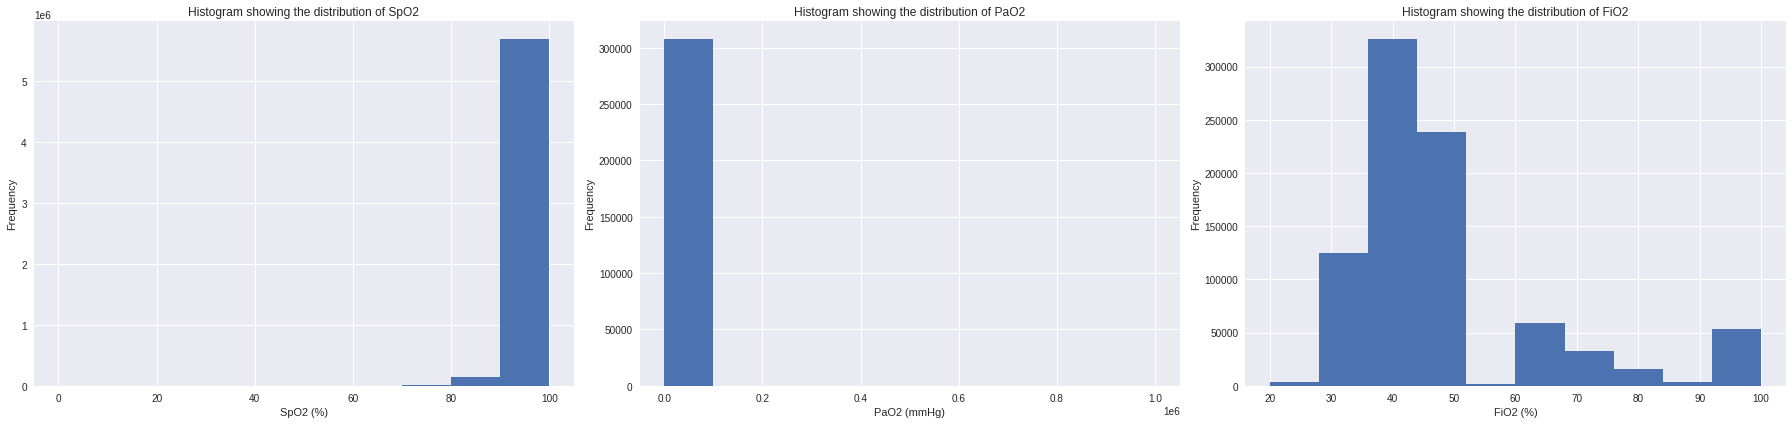

In [ ]:
plt.style.use('seaborn')
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))

ax1.hist(sofa_spo2_pao2_fio2_hospexpflag['spo2']) 
ax1.set_title('Histogram showing the distribution of SpO2')
ax1.set_xlabel('SpO2 (%)')
ax1.set_ylabel('Frequency')

ax2.hist(sofa_spo2_pao2_fio2_hospexpflag['pao2']) 
ax2.set_title('Histogram showing the distribution of PaO2')
ax2.set_xlabel('PaO2 (mmHg)')
ax2.set_ylabel('Frequency')

ax3.hist(sofa_spo2_pao2_fio2_hospexpflag['fio2']) 
ax3.set_title('Histogram showing the distribution of FiO2')
ax3.set_xlabel('FiO2 (%)')
ax3.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Removing spo2, pao2, and fio2 values ≤ 0

We need to remove from the spo2, pao2, and fio2 columns values less or equal to 0. 

In [ ]:
# df without removing spo2, pao2, and fio2 ≤ 0 values
sofa_spo2_pao2_fio2_hospexpflag[['spo2','pao2','fio2']].describe()

spo2           pao2           fio2
count  5.869337e+06  308043.000000  860394.000000
mean   9.668517e+01     247.246644      48.785695
std    3.253353e+00   10657.560346      16.827594
min    1.000000e-02     -17.000000      20.000000
25%    9.500000e+01      85.000000      40.000000
50%    9.700000e+01     109.000000      40.000000
75%    9.900000e+01     149.000000      50.000000
max    1.000000e+02  999999.000000     100.000000

In [ ]:
sofa_spo2_pao2_fio2_hospexpflag.shape

(6358767, 33)

In [ ]:
# Removing values ≤ 0 
sofa_spo2_pao2_fio2_hospexpflag_zero_clean = sofa_spo2_pao2_fio2_hospexpflag.loc[~((sofa_spo2_pao2_fio2_hospexpflag['spo2']<=0) | (sofa_spo2_pao2_fio2_hospexpflag['pao2']<=0) | (sofa_spo2_pao2_fio2_hospexpflag['fio2']<=0))]


In [ ]:
sofa_spo2_pao2_fio2_hospexpflag_zero_clean.shape 

(6358758, 33)

In [ ]:
sofa_spo2_pao2_fio2_hospexpflag_zero_clean['stay_id'].nunique()

76519

In [ ]:
# How many rows have been deleted?
6358767-6358758

9

In [ ]:
# df removing values less or equal to 0 
sofa_spo2_pao2_fio2_hospexpflag_zero_clean[['spo2','pao2','fio2']].describe()

spo2           pao2           fio2
count  5.869328e+06  308034.000000  860394.000000
mean   9.668516e+01     247.253923      48.785695
std    3.253354e+00   10657.715955      16.827594
min    1.000000e-02       1.000000      20.000000
25%    9.500000e+01      85.000000      40.000000
50%    9.700000e+01     109.000000      40.000000
75%    9.900000e+01     149.000000      50.000000
max    1.000000e+02  999999.000000     100.000000

In [ ]:
# Save sofa_spo2_pao2_fio2_hospexpflag_zero_clean as csv to Google Drive
sofa_spo2_pao2_fio2_hospexpflag_zero_clean.to_csv('sofa_spo2_pao2_fio2_hospexpflag_zero_clean.csv', index=False)
!cp sofa_spo2_pao2_fio2_hospexpflag_zero_clean.csv "drive/My Drive/TFG/" 

In [ ]:
# Read csv from Google Drive in Google Colab 
sofa_spo2_pao2_fio2_hospexpflag_zero_clean = pd.read_csv('drive/My Drive/TFG//sofa_spo2_pao2_fio2_hospexpflag_zero_clean.csv')
sofa_spo2_pao2_fio2_hospexpflag_zero_clean.head(2)

## Outlier detection and removal 

IQR based filtering:
- Used when our data distribution is skewed.
- For Skewed distributions: Use Inter-Quartile Range (IQR) proximity rule.
– The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.
- Where Q1 and Q3 are the 25th and 75th percentile of the dataset respectively, and IQR represents the inter-quartile range and given by Q3 – Q1.
- https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/

To remove the outliers for multiple columns we are going to use a two-step apporach:
  1. We are going to extract all the outliers for all the columns 
  2. We are going to use the indexes of these outliers and remove them from the original df

In [ ]:
def outliers(df, ft):
  Q1 = df[ft].quantile(0.25)
  Q3 = df[ft].quantile(0.75)
  IQR = Q3-Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # list to store indexes of the outliers 
  ls = df.index[(df[ft]< lower_bound) | (df[ft]> upper_bound)]

  return ls

In [ ]:
def remove(df, ls):
  ls = sorted(set(ls))
  df = df.drop(ls)
  return df

In [ ]:
sofa_spo2_pao2_fio2_hospexpflag_outliers = sofa_spo2_pao2_fio2_hospexpflag_zero_clean.copy()

index_list = []
for feature in ['spo2', 'pao2']:
  index_list.extend(outliers(sofa_spo2_pao2_fio2_hospexpflag_outliers, feature))

In [ ]:
sofa_spo2_pao2_fio2_hospexpflag_outliers_clean = remove(sofa_spo2_pao2_fio2_hospexpflag_outliers, index_list)

In [ ]:
sofa_spo2_pao2_fio2_hospexpflag_outliers_clean[['spo2', 'pao2', 'fio2']].describe()

spo2           pao2           fio2
count  5.776137e+06  273009.000000  836182.000000
mean   9.688199e+01     113.247010      48.139256
std    2.556912e+00      39.910789      16.055342
min    8.900000e+01       1.000000      20.000000
25%    9.500000e+01      84.000000      40.000000
50%    9.700000e+01     104.000000      40.000000
75%    9.900000e+01     135.000000      50.000000
max    1.000000e+02     245.000000     100.000000

In [ ]:
print(sofa_spo2_pao2_fio2_hospexpflag_outliers_clean.shape)
print("Unique patients:",sofa_spo2_pao2_fio2_hospexpflag_outliers_clean['stay_id'].nunique())

(6249593, 33)
Unique patients: 76480


In [ ]:
# initial df - final sofa_spo2_pao2_fio2_hospexpflag_outliers_clean df
print(6358767-6249593)
# <=0 cleaned df - sofa_spo2_pao2_fio2_hospexpflag_outliers_clean df
print(6358758-6249593)

109174
109165


In [ ]:
# Save sofa_spo2_pao2_fio2_hospexpflag_outliers_clean as csv to Google Drive
sofa_spo2_pao2_fio2_hospexpflag_outliers_clean.to_csv('sofa_spo2_pao2_fio2_hospexpflag_outliers_clean.csv', index=False)
!cp sofa_spo2_pao2_fio2_hospexpflag_outliers_clean.csv "drive/My Drive/TFG/"

In [ ]:
# Read csv from Google Drive in Google Colab 
sofa_spo2_pao2_fio2_hospexpflag_outliers_clean = pd.read_csv('drive/My Drive/TFG/sofa_spo2_pao2_fio2_hospexpflag_outliers_clean.csv')
sofa_spo2_pao2_fio2_hospexpflag_outliers_clean.head(2)

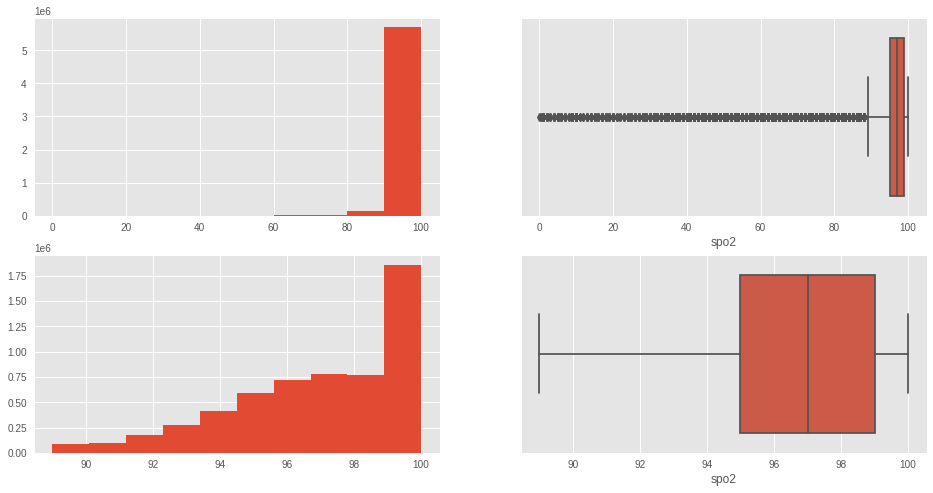

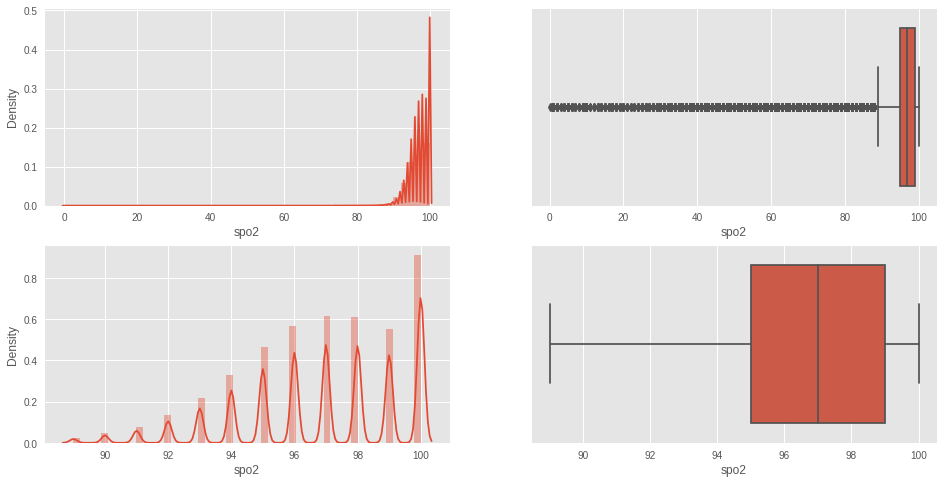

In [ ]:
# SpO2
plt.style.use('ggplot')
# Compare the plots
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.hist(sofa_spo2_pao2_fio2_hospexpflag_zero_clean['spo2'])
plt.subplot(2,2,2)
sns.boxplot(sofa_spo2_pao2_fio2_hospexpflag_zero_clean['spo2'])
plt.subplot(2,2,3)
plt.hist(sofa_spo2_pao2_fio2_hospexpflag_outliers_clean['spo2'])
plt.subplot(2,2,4)
sns.boxplot(sofa_spo2_pao2_fio2_hospexpflag_outliers_clean['spo2'])
# Compare the plots
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(sofa_spo2_pao2_fio2_hospexpflag_zero_clean['spo2'])
plt.subplot(2,2,2)
sns.boxplot(sofa_spo2_pao2_fio2_hospexpflag_zero_clean['spo2'])
plt.subplot(2,2,3)
sns.distplot(sofa_spo2_pao2_fio2_hospexpflag_outliers_clean['spo2'])
plt.subplot(2,2,4)
sns.boxplot(sofa_spo2_pao2_fio2_hospexpflag_outliers_clean['spo2'])
plt.show()

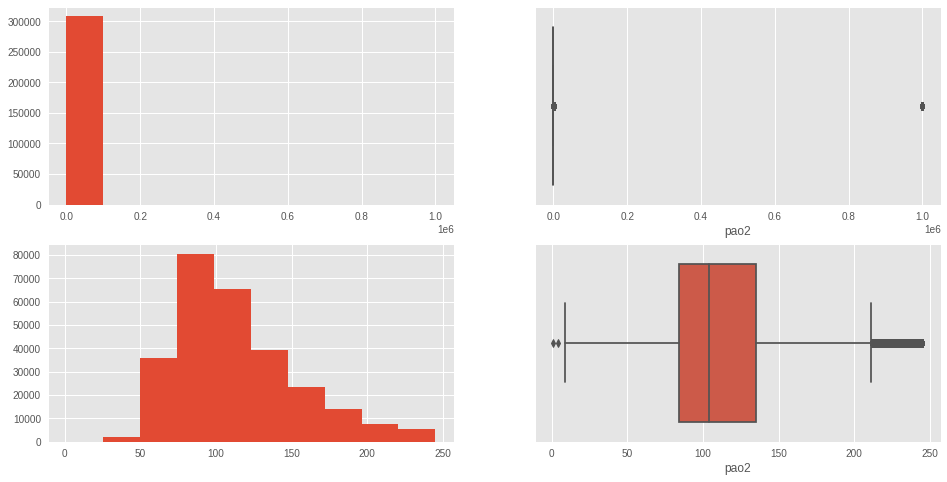

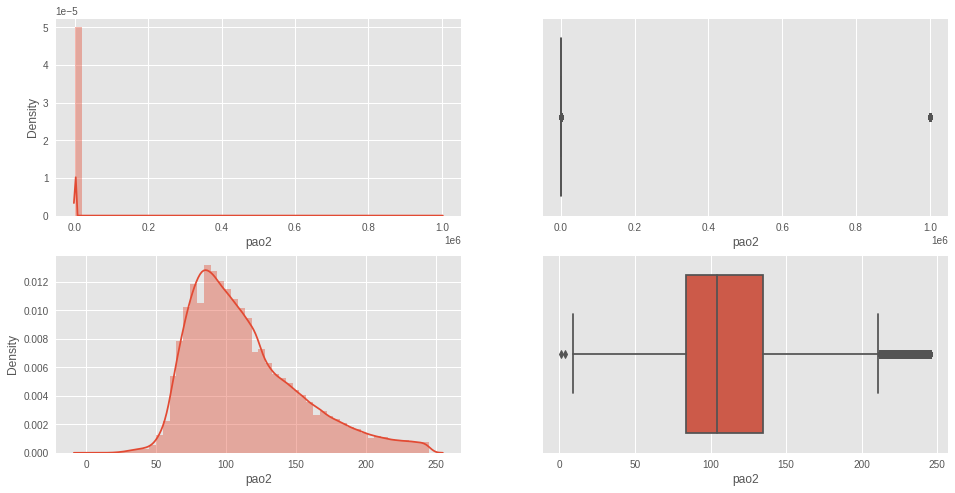

In [ ]:
#  PaO2
plt.style.use('ggplot')
# Compare the plots
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.hist(sofa_spo2_pao2_fio2_hospexpflag_zero_clean['pao2'])
plt.subplot(2,2,2)
sns.boxplot(sofa_spo2_pao2_fio2_hospexpflag_zero_clean['pao2'])
plt.subplot(2,2,3)
plt.hist(sofa_spo2_pao2_fio2_hospexpflag_outliers_clean['pao2'])
plt.subplot(2,2,4)
sns.boxplot(sofa_spo2_pao2_fio2_hospexpflag_outliers_clean['pao2'])
# Compare the plots
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(sofa_spo2_pao2_fio2_hospexpflag_zero_clean['pao2'])
plt.subplot(2,2,2)
sns.boxplot(sofa_spo2_pao2_fio2_hospexpflag_zero_clean['pao2'])
plt.subplot(2,2,3)
sns.distplot(sofa_spo2_pao2_fio2_hospexpflag_outliers_clean['pao2'])
plt.subplot(2,2,4)
sns.boxplot(sofa_spo2_pao2_fio2_hospexpflag_outliers_clean['pao2'])
plt.show()

### Distribution plots without outliers 

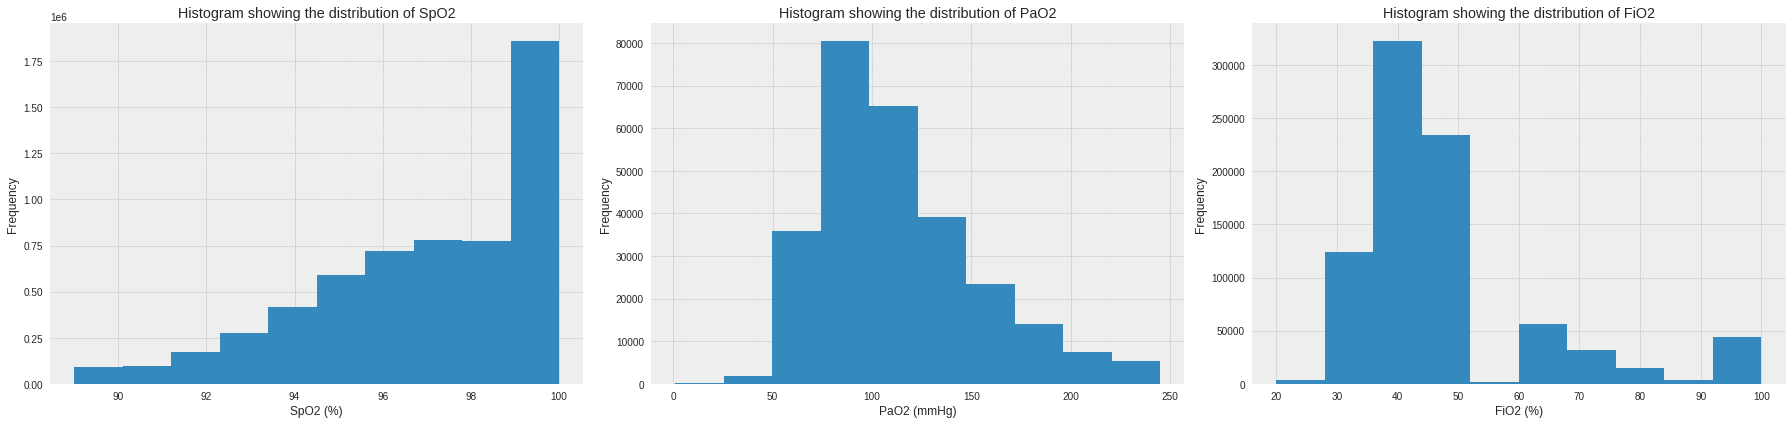

In [ ]:
plt.style.use('bmh')
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
# SpO2
ax1.hist(sofa_spo2_pao2_fio2_hospexpflag_outliers_clean['spo2']) 
ax1.set_title('Histogram showing the distribution of SpO2')
ax1.set_xlabel('SpO2 (%)')
ax1.set_ylabel('Frequency')
# PaO2
ax2.hist(sofa_spo2_pao2_fio2_hospexpflag_outliers_clean['pao2']) 
ax2.set_title('Histogram showing the distribution of PaO2')
ax2.set_xlabel('PaO2 (mmHg)')
ax2.set_ylabel('Frequency')
# FiO2
ax3.hist(sofa_spo2_pao2_fio2_hospexpflag_outliers_clean['fio2']) 
ax3.set_title('Histogram showing the distribution of FiO2')
ax3.set_xlabel('FiO2 (%)')
ax3.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Daily frequency of PaO2 values vs the daily frequency of SpO2 values 


In [ ]:
patient_hour = sofa_spo2_pao2_fio2_hospexpflag_outliers_clean.groupby('stay_id', as_index=False).agg({'hr':'max'})  
patient_hour.rename({'hr':'hr_totals'}, axis=1, inplace=True)

In [ ]:
pao2_registers = sofa_spo2_pao2_fio2_hospexpflag_outliers_clean[sofa_spo2_pao2_fio2_hospexpflag_outliers_clean['pao2'].notnull()].groupby('stay_id', as_index=False).agg({'hr':'nunique'}) #.head()
pao2_registers.rename({'hr':'pao2_registers'}, axis=1, inplace=True)

In [ ]:
spo2_registers = sofa_spo2_pao2_fio2_hospexpflag_outliers_clean[sofa_spo2_pao2_fio2_hospexpflag_outliers_clean['spo2'].notnull()].groupby('stay_id', as_index=False).agg({'hr':'nunique'}) #.head()
spo2_registers.rename({'hr':'spo2_registers'}, axis=1, inplace=True)

In [ ]:
dummy_union = pd.merge(patient_hour, pao2_registers, on='stay_id', how='inner')
union = pd.merge(dummy_union, spo2_registers, on='stay_id', how='inner')

In [ ]:
union['registers_pao2_day'] = round(union['pao2_registers']/(union['hr_totals']/24),1)
union['registers_spo2_day'] = round(union['spo2_registers']/(union['hr_totals']/24),1)

In [ ]:
print(sofa_spo2_pao2_fio2_hospexpflag_outliers_clean.shape)
print(sofa_spo2_pao2_fio2_hospexpflag_outliers_clean['stay_id'].nunique())
print(patient_hour.shape)
print(pao2_registers.shape)
print(spo2_registers.shape)
print(dummy_union.shape)
print(union.shape)

(6249593, 33)
76480
(76480, 2)
(32872, 2)
(76158, 2)
(32872, 3)
(32780, 6)


In [ ]:
union['registers_pao2_day'].describe()

count    32780.0
mean         inf
std          NaN
min          0.0
25%          0.6
50%          1.3
75%          2.6
max          inf
Name: registers_pao2_day, dtype: float64

In [ ]:
union['registers_spo2_day'].describe()

count    32780.0
mean         inf
std          NaN
min          0.4
25%         21.8
50%         23.0
75%         23.6
max          inf
Name: registers_spo2_day, dtype: float64

In [ ]:
df_pao2 = union[['stay_id','registers_pao2_day']]
df_spo2 = union[['stay_id',"registers_spo2_day"]]

In [ ]:
df_pao2.loc[:,'Methods'] = 'pao2'
df_spo2.loc[:,'Methods'] = 'spo2'


In [ ]:
df_pao2.rename({"registers_pao2_day":'Daily registers'}, axis=1, inplace=True)
df_pao2.drop({'stay_id'}, axis=1, inplace=True)
df_spo2.rename({"registers_spo2_day":'Daily registers'}, axis=1, inplace=True)
df_spo2.drop({'stay_id'}, axis=1, inplace=True)

In [ ]:
df_pao2

Daily registers Methods
0                  1.2    pao2
1                  0.2    pao2
2                  5.2    pao2
3                  0.9    pao2
4                  0.6    pao2
...                ...     ...
32775              4.5    pao2
32776              0.8    pao2
32777              1.5    pao2
32778              2.3    pao2
32779              2.9    pao2

[32780 rows x 2 columns]

In [ ]:
df_boxplot = pd.concat([df_pao2, df_spo2])
df_boxplot

Daily registers Methods
0                  1.2    pao2
1                  0.2    pao2
2                  5.2    pao2
3                  0.9    pao2
4                  0.6    pao2
...                ...     ...
32775             22.5    spo2
32776             23.8    spo2
32777             22.7    spo2
32778             25.1    spo2
32779             23.0    spo2

[65560 rows x 2 columns]

In [ ]:
df_pivoted = df_boxplot.pivot(columns='Methods', values='Daily registers')
df_pivoted

Methods  pao2  spo2
0         1.2  22.8
1         0.2  23.6
2         5.2  19.8
3         0.9  18.7
4         0.6  24.6
...       ...   ...
32775     4.5  22.5
32776     0.8  23.8
32777     1.5  22.7
32778     2.3  25.1
32779     2.9  23.0

[32780 rows x 2 columns]

In [ ]:
# Violin plot: daily frequency per patient and day 
import plotly.express as px
fig = px.violin(df_boxplot, x="Methods", y="Daily registers", color="Methods")
fig.update_traces(hoverinfo='skip')
fig.update_layout(
    title="Daily frequency of PaO2 values vs daily frequency of SpO2 values")
fig.show()

## Filling NaN values using the forward fill method

Data imputation:
- Before performing any analysis, we have to handle missing data. 
- For each patient we forward-fill SpO2, PaO2, and FiO2 missing values replacing them with the value from the previous row.
  - For each patient: group by stay_id



In [ ]:
sofa_spo2_pao2_fio2_hospexpflag_clean = sofa_spo2_pao2_fio2_hospexpflag_outliers_clean.copy()

In [ ]:
# replace NaNs by preceding or next values
sofa_spo2_pao2_fio2_hospexpflag_clean[['spo2', 'pao2', 'fio2']] = sofa_spo2_pao2_fio2_hospexpflag_clean.groupby('stay_id')[['spo2', 'pao2', 'fio2']].fillna(method='ffill') 


In [ ]:
# original df
sofa_spo2_pao2_fio2_hospexpflag_clean[['spo2', 'pao2', 'fio2']].isnull().sum()
"""
spo2                       489430
pao2                      6050724
fio2                      5498373
"""

In [ ]:
# Df without outliers
sofa_spo2_pao2_fio2_hospexpflag_outliers_clean[['spo2', 'pao2', 'fio2']].isnull().sum()

spo2     473456
pao2    5976584
fio2    5413411
dtype: int64

In [ ]:
# Clean df with ffill()
# There will be as many nulls as hours the patient spent without a first measurement (of all the variables)
sofa_spo2_pao2_fio2_hospexpflag_clean[['spo2', 'pao2', 'fio2']].isnull().sum()

spo2      13184
pao2    2745136
fio2    2061067
dtype: int64

In [ ]:
# Save sofa_spo2_pao2_fio2_hospexpflag_clean as csv to Google Drive
sofa_spo2_pao2_fio2_hospexpflag_clean.to_csv('sofa_spo2_pao2_fio2_hospexpflag_clean.csv', index=False)
!cp sofa_spo2_pao2_fio2_hospexpflag_clean.csv "drive/My Drive/TFG/" 

In [ ]:
# Read csv from Google Drive in Google Colab 
sofa_spo2_pao2_fio2_hospexpflag_clean = pd.read_csv('drive/My Drive/TFG/sofa_spo2_pao2_fio2_hospexpflag_clean.csv')
sofa_spo2_pao2_fio2_hospexpflag_clean.head(2)

## Creating the SpO2/FiO2 ratio (SpFi)





 \begin{align}
    \text{SpFi} = \frac{SpO2}{FiO2}·{100}
    \end{align}


In [ ]:
sofa_spo2_pao2_fio2_hospexpflag_spfi = sofa_spo2_pao2_fio2_hospexpflag_clean.copy()
sofa_spo2_pao2_fio2_hospexpflag_spfi['spfi'] = (sofa_spo2_pao2_fio2_hospexpflag_spfi['spo2']/(sofa_spo2_pao2_fio2_hospexpflag_spfi['fio2']))*100

In [ ]:
sofa_spo2_pao2_fio2_hospexpflag_spfi.head(2)

In [ ]:
sofa_spo2_pao2_fio2_hospexpflag_spfi[['spo2','pao2','fio2','spfi']].isnull().sum() 

spo2      13184
pao2    2745136
fio2    2061067
spfi    2061832
dtype: int64

## Creating the PaO2/FiO2 ratio (PaFi)


 \begin{align}
    \text{PaFi} = \frac{PaO2}{FiO2}·{100}
    \end{align}

In [ ]:
sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi = sofa_spo2_pao2_fio2_hospexpflag_spfi.copy()
sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi['pafi'] = (sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi['pao2']/(sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi['fio2']))*100

In [ ]:
sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi.head(2)

In [ ]:
sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi[['spo2','pao2','fio2','spfi','pafi']].isnull().sum()

spo2      13184
pao2    2745136
fio2    2061067
spfi    2061832
pafi    2988453
dtype: int64

In [ ]:
print(sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi.shape)
print(sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi['stay_id'].nunique())

(6249593, 35)
76480


In [ ]:
# Save sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi as csv to Google Drive
sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi.to_csv('sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi.csv', index=False)
!cp sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi.csv "drive/My Drive/TFG/" 

In [ ]:
# Read csv from Google Drive in Google Colab 
sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi = pd.read_csv('drive/My Drive/TFG/sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi.csv')
sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi.head(2)

stay_id  hr            starttime              endtime  \
0  30002415   4  2126-12-17 15:00:00  2126-12-17 16:00:00   
1  30002415  19  2126-12-18 06:00:00  2126-12-18 07:00:00   

   pao2fio2ratio_novent  pao2fio2ratio_vent  rate_epinephrine  \
0                   NaN                 NaN               NaN   
1                   NaN                 NaN               NaN   

   rate_norepinephrine  rate_dopamine  rate_dobutamine  ...  \
0                  NaN            NaN              NaN  ...   
1                  NaN            NaN              NaN  ...   

   cardiovascular_24hours  cns_24hours  renal_24hours  sofa_24hours  spo2  \
0                       0            0              0             4  99.0   
1                       0            0              0             4  94.0   

    pao2  fio2  hospital_expire_flag        spfi        pafi  
0  163.0  35.0                     0  282.857143  465.714286  
1  163.0  35.0                     0  268.571429  465.714286  

[2 rows x 35 columns]

## Correlation between the SpO2/FiO2 (SpFi) ratio and the PaO2/FiO2 (PaFi) ratio: S/F ratio vs P/F ratio

In [ ]:
sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi[['pafi','spfi']].describe()

pafi          spfi
count  3.261140e+06  4.187761e+06
mean   2.594956e+02  2.188935e+02
std    1.195707e+02  5.804867e+01
min    1.000000e+00  8.900000e+01
25%    1.720000e+02  1.900000e+02
50%    2.375000e+02  2.350000e+02
75%    3.275000e+02  2.500000e+02
max    1.166667e+03  5.000000e+02

### Normality Tests

#### Statistical Tests for Normality

Jarque–Bera test:
- The hypotheses:
  - H0: sample S and sample K are not significantly different from a normal distribution
  - H1: sample S and sample K are significantly different from a normal distribution

- If the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
- If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.

- Jarque-Bera test works properly in large samples (usually larger than 2000 observations). 

  + https://pyshark.com/test-for-normality-using-python/
  + https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411
  + https://statologos.com/jarque-bera-test-python/
  + https://www.statology.org/jarque-bera-test-python/

In [ ]:
# Data preparation 
pafi = sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi['pafi'].values
pafi_clean = pafi[~np.isnan(pafi)]
spfi = sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi['spfi'].values
spfi_clean = spfi[~np.isnan(spfi)]

In [ ]:
# Check length of the data
print(len(pafi_clean))
print(len(spfi_clean))

3261140
4187761


In [ ]:
# Jarque–Bera test for Normality

# Function to check normality
def check_normality(pvalue):
  if pvalue > 0.05:
      print('Since the p-value > 0.05, we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.')
  else:
    print('Since p-value ≤ 0.05, we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.')

# Perform Jarque-Bera test
print(stats.jarque_bera(pafi_clean))
statistic, pvalue = jarque_bera(pafi_clean)
check_normality(pvalue)
print("\n")
print(stats.jarque_bera(spfi_clean))
statistic, pvalue = jarque_bera(spfi_clean)
check_normality(pvalue)

Jarque_beraResult(statistic=682500.8055669168, pvalue=0.0)
Since p-value ≤ 0.05, we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.


Jarque_beraResult(statistic=60278.08662666681, pvalue=0.0)
Since p-value ≤ 0.05, we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.


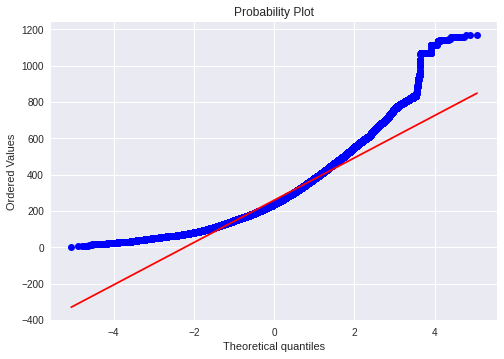

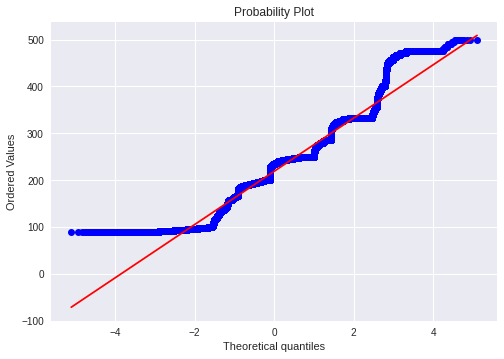

In [ ]:
# Quantile-Quantile Plot
stats.probplot(pafi_clean, dist='norm', plot=pylab) # PaFi
pylab.show()

print("\n")

stats.probplot(spfi_clean, dist='norm', plot=pylab) # Spfi
pylab.show()

- Neither PaFi nor SpFi follow a normal distribution.
- We must use nonparametric rank correlation methods: Spearman’s rho test or Kendall’s tau test. 


### Spearman’s rho test 

In [ ]:
# Measuring correlation between two variables
sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi[['pafi','spfi']].corr(method='spearman').style.background_gradient(cmap='coolwarm') 

In [ ]:
# R-squared
import statsmodels.api as sm
from numpy import NaN
x = sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi['pafi']
y = sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi['spfi']
model = sm.OLS(y, x, missing='drop')
results = model.fit()
print('Parameters: ', results.params)
print('R2: ', results.rsquared)

Parameters:  pafi    0.747411
dtype: float64
R2:  0.8950851926757373


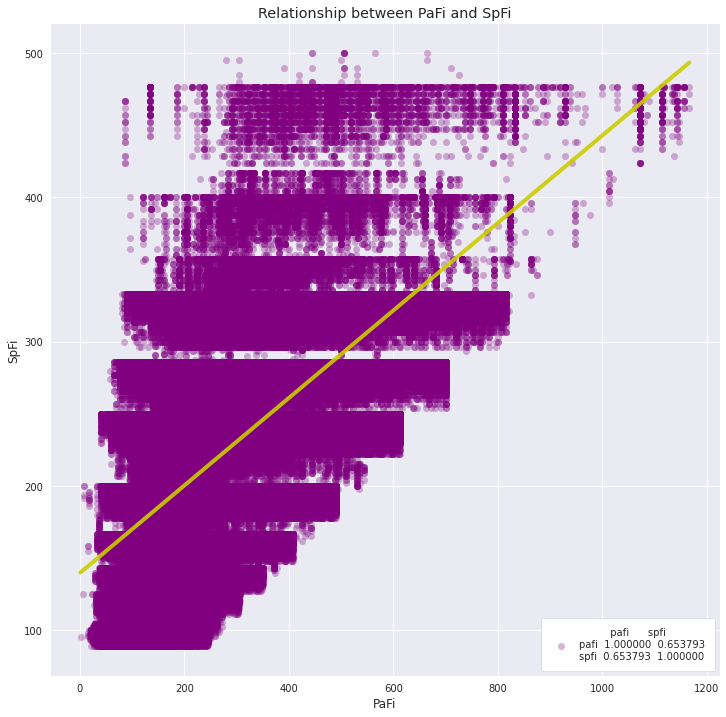

In [ ]:
# Correlation scatter plot with the linear regression fit line
plt.figure(figsize=(12, 12))       
fig = sns.regplot(x="pafi", y="spfi", data=sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi, ci=None, 
                  label="{}".format(sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi[['pafi','spfi']].corr(method='spearman')), 
                  fit_reg=True, scatter_kws = {'color': 'purple', 'alpha': 0.3}, line_kws = {'color': '#CCCC00', 'alpha': 0.9, 'lw':4})
fig.set(xlabel='PaFi', ylabel='SpFi', title = "Relationship between PaFi and SpFi")
sns.set_style('darkgrid') 
plt.legend(facecolor='white',frameon=True, fancybox=True, framealpha=1, borderpad=1)
  # facecolor: The legend's background color
  # frameon: Whether the legend should be drawn on a patch (frame).
  # fancybox: Whether round edges should be enabled around the FancyBboxPatch which makes up the legend's background.
  # framealpha: The alpha transparency of the legend's background
  # borderpad: The fractional whitespace inside the legend border, in font-size units.
plt.show()

## New respriatory SOFA score 

### Only rows where SpFi and PaFi are not null

In [ ]:
sofa_new_clean = sofa_spo2_pao2_fio2_hospexpflag_spfi_pafi.copy()

In [ ]:
print(sofa_new_clean.shape)
print(sofa_new_clean['stay_id'].nunique())

(6249593, 35)
76480


In [ ]:
sofa_new_clean = sofa_new_clean[(~sofa_new_clean['pafi'].isnull()) & (~sofa_new_clean['spfi'].isnull())]

In [ ]:
print(sofa_new_clean.shape)
print(sofa_new_clean['stay_id'].nunique())

(3260787, 35)
28491


In [ ]:
sofa_new_clean[['pafi','spfi']].isnull().sum()

pafi    0
spfi    0
dtype: int64

In [ ]:
display(sofa_new_clean[['pafi','spfi']].head(10))
print(sofa_new_clean.shape)

pafi        spfi
0    465.714286  282.857143
1    465.714286  268.571429
106  252.500000  242.500000
146  426.000000  186.000000
147  426.000000  194.000000
214  275.000000  242.500000
215  275.000000  245.000000
262  403.333333  166.666667
263  403.333333  155.000000
264  403.333333  156.666667

(3260787, 35)


### SOFA based on PaFi

Respiratory SOFA score: 
0. PaFi ≥ 400
1. PaFi < 400 and ≥ 300
2. PaFi < 300 and ≥ 200
3. PaFi < 200 and ≥ 100
4. PaFi < 100


In [ ]:
sofa_new = sofa_new_clean.copy()

In [ ]:
conditions = [
    (sofa_new['pafi']>=400),
    (sofa_new['pafi']<400) & (sofa_new['pafi']>=300),
    (sofa_new['pafi']<300) & (sofa_new['pafi']>=200),
    (sofa_new['pafi']<200) & (sofa_new['pafi']>=100),
    (sofa_new['pafi']<100)
]

sofa_scores = [0,1,2,3,4]

sofa_new['sofa_pafi'] = np.select(conditions, sofa_scores)

In [ ]:
sofa_new[['pafi','sofa_pafi']].isnull().sum()

pafi         0
sofa_pafi    0
dtype: int64

In [ ]:
sofa_new.groupby(['sofa_pafi'], as_index=False).agg({'pafi':'median', 'spfi':'median'})

sofa_pafi        pafi   spfi
0          0  463.333333  250.0
1          1  340.000000  245.0
2          2  242.500000  240.0
3          3  160.000000  190.0
4          4   82.500000  100.0

Checking how many pafi and spfi values are in each category: 


In [ ]:
# subset 
sofa_new_pafi = sofa_new[['sofa_pafi', 'pafi', 'spfi']]

In [ ]:
sofa_new_pafi.head(3)

sofa_pafi        pafi        spfi
0            0  465.714286  282.857143
1            0  465.714286  268.571429
106          2  252.500000  242.500000

In [ ]:
sofa_new_pafi.groupby('sofa_pafi').count()

pafi     spfi
sofa_pafi                  
0           424783   424783
1           606483   606483
2          1077270  1077270
3           994648   994648
4           157603   157603

In [ ]:
sofa_new_pafi_count = sofa_new_pafi.groupby('sofa_pafi').count().reset_index()[['pafi']]
sofa_new_pafi_count['sofa_score'] = sofa_new_pafi.groupby('sofa_pafi').count().reset_index()[['pafi']].index # convert df index into column 
sofa_new_pafi_count

pafi  sofa_score
0   424783           0
1   606483           1
2  1077270           2
3   994648           3
4   157603           4

In [ ]:
sofa_new_pafi_count['pafi'].sum()

3260787

###### Creating the respiratory SOFA PaFi label (sofa_resp_pafi) and checking the SpFi distribution based on each respiratory SOFA PaFi score. 

In [ ]:
sofa_resp_pafi_4 = sofa_new[sofa_new['sofa_pafi']==4].groupby(['stay_id','hospital_expire_flag'], as_index=False).agg({'hr':'nunique'})
sofa_resp_pafi_4.rename({'hr':'srpafi4'}, axis=1, inplace=True)
sofa_resp_pafi_3 = sofa_new[sofa_new['sofa_pafi']==3].groupby(['stay_id','hospital_expire_flag'], as_index=False).agg({'hr':'nunique'})
sofa_resp_pafi_3.rename({'hr':'srpafi3'}, axis=1, inplace=True)
sofa_resp_pafi_2 = sofa_new[sofa_new['sofa_pafi']==2].groupby(['stay_id','hospital_expire_flag'], as_index=False).agg({'hr':'nunique'})
sofa_resp_pafi_2.rename({'hr':'srpafi2'}, axis=1, inplace=True)
sofa_resp_pafi_1 = sofa_new[sofa_new['sofa_pafi']==1].groupby(['stay_id','hospital_expire_flag'], as_index=False).agg({'hr':'nunique'})
sofa_resp_pafi_1.rename({'hr':'srpafi1'}, axis=1, inplace=True)
sofa_resp_pafi_0 = sofa_new[sofa_new['sofa_pafi']==0].groupby(['stay_id','hospital_expire_flag'], as_index=False).agg({'hr':'nunique'})
sofa_resp_pafi_0.rename({'hr':'srpafi0'}, axis=1, inplace=True)

sofa_resp_pafi_agg_dummy = pd.concat([sofa_resp_pafi_4, sofa_resp_pafi_3, sofa_resp_pafi_2, sofa_resp_pafi_1, sofa_resp_pafi_0]).sort_values(['stay_id']).reset_index(drop=True).fillna(0)
sofa_resp_pafi_agg = sofa_resp_pafi_agg_dummy.groupby(['stay_id','hospital_expire_flag'], as_index=False).agg({'srpafi4':'max','srpafi3':'max','srpafi2':'max','srpafi1':'max','srpafi0':'max'})

sofa_resp_pafi_agg['srpafi4%'] = round(sofa_resp_pafi_agg['srpafi4']/(sofa_resp_pafi_agg[['srpafi4','srpafi3','srpafi2','srpafi1','srpafi0']].sum(axis=1))*100,1)
sofa_resp_pafi_agg['srpafi3%'] = round(sofa_resp_pafi_agg['srpafi3']/(sofa_resp_pafi_agg[['srpafi4','srpafi3','srpafi2','srpafi1','srpafi0']].sum(axis=1))*100,1)
sofa_resp_pafi_agg['srpafi2%'] = round(sofa_resp_pafi_agg['srpafi2']/(sofa_resp_pafi_agg[['srpafi4','srpafi3','srpafi2','srpafi1','srpafi0']].sum(axis=1))*100,1)
sofa_resp_pafi_agg['srpafi1%'] = round(sofa_resp_pafi_agg['srpafi1']/(sofa_resp_pafi_agg[['srpafi4','srpafi3','srpafi2','srpafi1','srpafi0']].sum(axis=1))*100,1)
sofa_resp_pafi_agg['srpafi0%'] = round(sofa_resp_pafi_agg['srpafi0']/(sofa_resp_pafi_agg[['srpafi4','srpafi3','srpafi2','srpafi1','srpafi0']].sum(axis=1))*100,1)

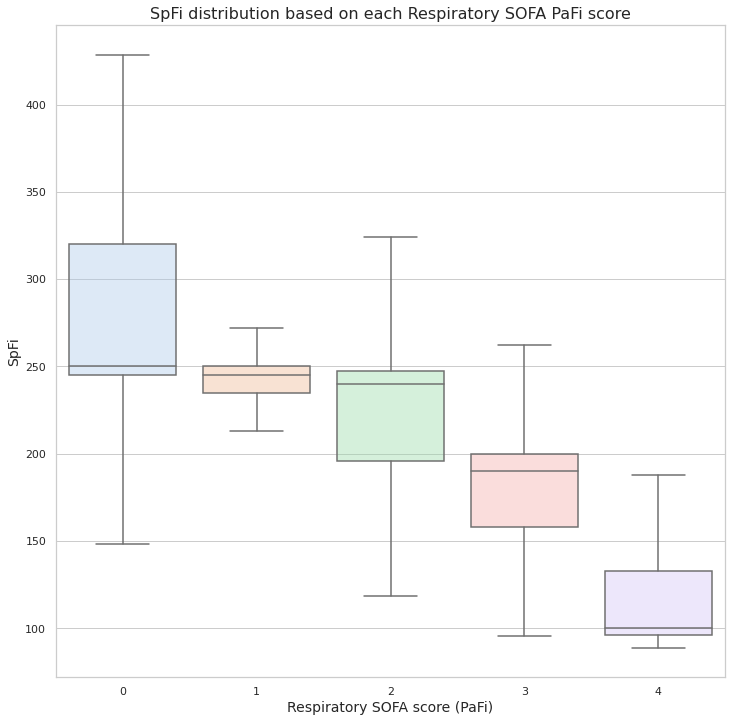

In [ ]:
# Box plot
sns.set(
        rc={"figure.figsize": (12, 12)}, style='whitegrid')  # width = 12, height = 12
b = sns.boxplot(data = sofa_new,           
                  x = "sofa_pafi",            # x axis column from data
                  y = "spfi",                 # y axis column from data
                  # width = 0.4,              # The width of the boxes
                  # color = "skyblue",        # Box colour
                  # linewidth = 2,            # Thickness of the box lines
                  palette ='pastel',          # color palettes
                  showfliers = False)         # Sop showing the fliers

# Set the y axis and font size
b.set_ylabel("SpFi", fontsize = 14)
# Set the x axis label and font size
b.set_xlabel("Respiratory SOFA score (PaFi)", fontsize = 14)
# Set the plot title with the pval variable and font size
b.set_title("SpFi distribution based on each Respiratory SOFA PaFi score", fontsize = 16)
# Remove axis spines
# sns.despine(offset = 2, trim = False)
# Adding transparency
for patch in b.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))
# Show the figure
plt.show();

In [ ]:
sofa_resp_pafi_agg['sofa_label'] = np.where((sofa_resp_pafi_agg['srpafi0%']>sofa_resp_pafi_agg['srpafi1%']) & (
                                        sofa_resp_pafi_agg['srpafi0%']>sofa_resp_pafi_agg['srpafi2%']) & (
                                        sofa_resp_pafi_agg['srpafi0%']>sofa_resp_pafi_agg['srpafi3%']) & (
                                        sofa_resp_pafi_agg['srpafi0%']>sofa_resp_pafi_agg['srpafi4%']), 0,
                                      np.where((sofa_resp_pafi_agg['srpafi1%']>sofa_resp_pafi_agg['srpafi2%']) & (
                                        sofa_resp_pafi_agg['srpafi1%']>sofa_resp_pafi_agg['srpafi3%']) & (
                                        sofa_resp_pafi_agg['srpafi1%']>sofa_resp_pafi_agg['srpafi4%']), 1,
                                      np.where((sofa_resp_pafi_agg['srpafi2%']>sofa_resp_pafi_agg['srpafi3%']) & (
                                        sofa_resp_pafi_agg['srpafi2%']>sofa_resp_pafi_agg['srpafi4%']), 2,
                                      np.where((sofa_resp_pafi_agg['srpafi3%']>sofa_resp_pafi_agg['srpafi4%']), 3, 4))))

In [ ]:
print(sofa_resp_pafi_agg.shape)
sofa_resp_pafi_agg.head()

(28491, 13)


stay_id  hospital_expire_flag  srpafi4  srpafi3  srpafi2  srpafi1  \
0  30000153                     0      0.0      0.0      0.0      0.0   
1  30000646                     1     55.0      0.0      0.0      0.0   
2  30001148                     0      0.0      0.0      1.0      4.0   
3  30001947                     0      0.0      0.0      0.0      0.0   
4  30002415                     0      0.0      0.0      1.0     12.0   

   srpafi0  srpafi4%  srpafi3%  srpafi2%  srpafi1%  srpafi0%  sofa_label  
0     39.0       0.0       0.0       0.0       0.0     100.0           0  
1      0.0     100.0       0.0       0.0       0.0       0.0           4  
2     12.0       0.0       0.0       5.9      23.5      70.6           0  
3      4.0       0.0       0.0       0.0       0.0     100.0           0  
4     11.0       0.0       0.0       4.2      50.0      45.8           1

In [ ]:
sofa_resp_pafi_agg.groupby('sofa_label')['hospital_expire_flag'].value_counts(normalize=True)

sofa_label  hospital_expire_flag
0           0                       0.868495
            1                       0.131505
1           0                       0.871027
            1                       0.128973
2           0                       0.843821
            1                       0.156179
3           0                       0.792156
            1                       0.207844
4           0                       0.609621
            1                       0.390379
Name: hospital_expire_flag, dtype: float64

In [ ]:
median_spfi = sofa_new.groupby('stay_id', as_index=False).agg({'spfi':'median'})

In [ ]:
sofa_resp_pafi_agg2 = pd.merge(sofa_resp_pafi_agg, median_spfi, on='stay_id', how='inner')

In [ ]:
print(sofa_resp_pafi_agg2.shape)
sofa_resp_pafi_agg2.head()

(28491, 14)


stay_id  hospital_expire_flag  srpafi4  srpafi3  srpafi2  srpafi1  \
0  30000153                     0      0.0      0.0      0.0      0.0   
1  30000646                     1     55.0      0.0      0.0      0.0   
2  30001148                     0      0.0      0.0      1.0      4.0   
3  30001947                     0      0.0      0.0      0.0      0.0   
4  30002415                     0      0.0      0.0      1.0     12.0   

   srpafi0  srpafi4%  srpafi3%  srpafi2%  srpafi1%  srpafi0%  sofa_label  \
0     39.0       0.0       0.0       0.0       0.0     100.0           0   
1      0.0     100.0       0.0       0.0       0.0       0.0           4   
2     12.0       0.0       0.0       5.9      23.5      70.6           0   
3      4.0       0.0       0.0       0.0       0.0     100.0           0   
4     11.0       0.0       0.0       4.2      50.0      45.8           1   

    spfi  
0  240.0  
1   95.0  
2  245.0  
3  247.5  
4  192.0

### Creation of the new respiratory SOFA score 

##### Group generation of the new respiratory SOFA score based on the SpFi ratio, considering the descriptive statistics table (median, Q1 and Q3). 

In [ ]:
def q25(x): return x.quantile(0.25)
def q75(x): return x.quantile(0.75)
sofa_new.groupby('sofa_pafi', as_index=False).agg({'spfi':['min','max','mean','median',q25,q75]})

sofa_pafi        spfi                                                       
                    min         max        mean median         q25         q75
0         0  148.333333  500.000000  271.144949  250.0  245.000000  320.000000
1         1  111.250000  495.000000  247.475897  245.0  235.000000  250.000000
2         2   89.000000  495.000000  227.090685  240.0  196.000000  247.500000
3         3   89.000000  476.190476  184.285342  190.0  158.333333  200.000000
4         4   89.000000  466.666667  120.944177  100.0   96.000000  132.857143

In [ ]:
sofa_new['sofa_spfi_boxplots'] = np.where(sofa_new['spfi']>245,0,
                                          np.where(sofa_new['spfi']>235,1,
                                                   np.where(sofa_new['spfi']>195,2,
                                                            np.where(sofa_new['spfi']>133,3,4))))

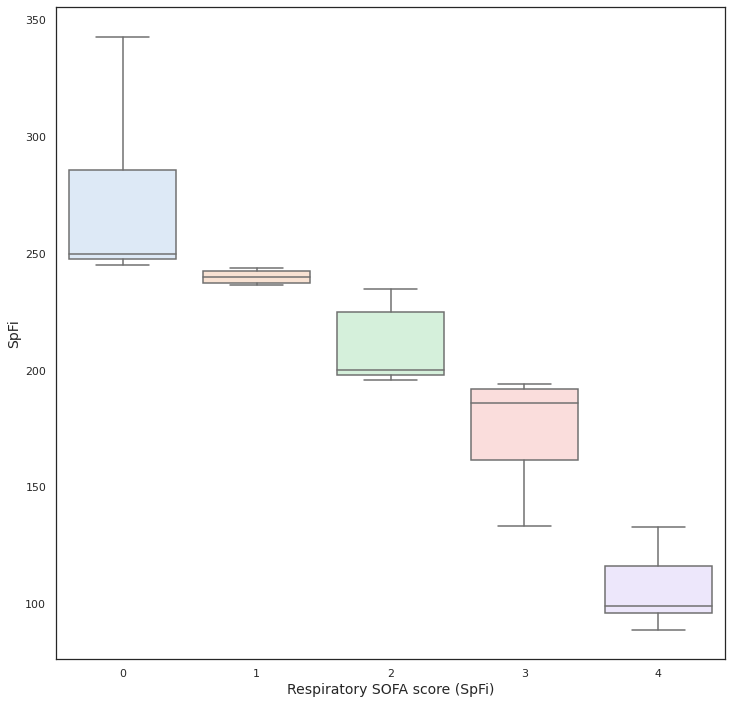

In [ ]:
# Box plot
sns.set(
        rc={"figure.figsize": (12, 12)}, style='white')  # width = 12, height = 12
b = sns.boxplot(data = sofa_new,           
                  x = "sofa_spfi_boxplots",            # x axis column from data
                  y = "spfi",                 # y axis column from data
                  # width = 0.4,              # The width of the boxes
                  # color = "skyblue",        # Box colour
                  # linewidth = 2,            # Thickness of the box lines
                  palette ='pastel',          # color palettes
                  showfliers = False)         # Sop showing the fliers

# Set the y axis and font size
b.set_ylabel("SpFi", fontsize = 14)
# Set the x axis label and font size
b.set_xlabel("Respiratory SOFA score (SpFi)", fontsize = 14)
# Set the plot title with the pval variable and font size
# b.set_title("", fontsize = 16)
# Remove axis spines
# sns.despine(offset = 2, trim = False)
# Adding transparency
for patch in b.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))
# Show the figure
plt.show();

##### Distance between SOFA PaFi score and SOFA SpFi score

In [ ]:
sofa_new['sofa_diff_1'] = sofa_new['sofa_spfi_boxplots'] - sofa_new['sofa_pafi']
sofa_new['sofa_abs_diff_1'] = abs(sofa_new['sofa_spfi_boxplots'] - sofa_new['sofa_pafi'])

In [ ]:
sofa_new[['stay_id','sofa_pafi','sofa_spfi_boxplots','sofa_diff_1','sofa_abs_diff_1']].head()

stay_id  sofa_pafi  sofa_spfi_boxplots  sofa_diff_1  sofa_abs_diff_1
0    30002415          0                   0            0                0
1    30002415          0                   0            0                0
106  30129989          2                   1           -1                1
146  30194453          0                   3            3                3
147  30194453          0                   3            3                3

###### Histogram showing the distance between respiratory SOFA SpFi score and respiratory SOFA PaFi score

In [ ]:
# Difference between SOFA SpFi and SOFA PaFi
sofa_new['sofa_diff_1'].value_counts(normalize=True) # or sofa_new['sofa_diff_1'].value_counts()/sofa_new['sofa_diff_1'].count()

 0    0.382818
-1    0.235284
 1    0.155198
-2    0.147575
 2    0.037784
-3    0.033922
 3    0.005971
-4    0.001448
Name: sofa_diff_1, dtype: float64

- 38% of the time both SOFA PaFi and SpFi have the same score.  

In [ ]:
import plotly.express as px
fig = px.histogram(sofa_new, x="sofa_diff_1", color="sofa_diff_1", 
                    labels={
                            "sofa_diff_1": "Distance"},
                   title="Histogram showing the distance between respiratory SOFA SpFi and respiratory SOFA PaFi")
fig.show()

#### Creating the respiratory SOFA SpFi label (sofa_resp_spfi)


In [ ]:
sofa_resp_spfi_4 = sofa_new[sofa_new['sofa_spfi_boxplots']==4].groupby(['stay_id','hospital_expire_flag'], as_index=False).agg({'hr':'nunique'})
sofa_resp_spfi_4.rename({'hr':'srspfi4'}, axis=1, inplace=True)
sofa_resp_spfi_3 = sofa_new[sofa_new['sofa_spfi_boxplots']==3].groupby(['stay_id','hospital_expire_flag'], as_index=False).agg({'hr':'nunique'})
sofa_resp_spfi_3.rename({'hr':'srspfi3'}, axis=1, inplace=True)
sofa_resp_spfi_2 = sofa_new[sofa_new['sofa_spfi_boxplots']==2].groupby(['stay_id','hospital_expire_flag'], as_index=False).agg({'hr':'nunique'})
sofa_resp_spfi_2.rename({'hr':'srspfi2'}, axis=1, inplace=True)
sofa_resp_spfi_1 = sofa_new[sofa_new['sofa_spfi_boxplots']==1].groupby(['stay_id','hospital_expire_flag'], as_index=False).agg({'hr':'nunique'})
sofa_resp_spfi_1.rename({'hr':'srspfi1'}, axis=1, inplace=True)
sofa_resp_spfi_0 = sofa_new[sofa_new['sofa_spfi_boxplots']==0].groupby(['stay_id','hospital_expire_flag'], as_index=False).agg({'hr':'nunique'})
sofa_resp_spfi_0.rename({'hr':'srspfi0'}, axis=1, inplace=True)

sofa_resp_spfi_agg_dummy = pd.concat([sofa_resp_spfi_4, sofa_resp_spfi_3, sofa_resp_spfi_2, sofa_resp_spfi_1, sofa_resp_spfi_0]).sort_values(['stay_id']).reset_index(drop=True).fillna(0)
sofa_resp_spfi_agg = sofa_resp_spfi_agg_dummy.groupby(['stay_id','hospital_expire_flag'], as_index=False).agg({'srspfi4':'max','srspfi3':'max','srspfi2':'max','srspfi1':'max','srspfi0':'max'})

sofa_resp_spfi_agg['srspfi4%'] = round(sofa_resp_spfi_agg['srspfi4']/(sofa_resp_spfi_agg[['srspfi4','srspfi3','srspfi2','srspfi1','srspfi0']].sum(axis=1))*100,1)
sofa_resp_spfi_agg['srspfi3%'] = round(sofa_resp_spfi_agg['srspfi3']/(sofa_resp_spfi_agg[['srspfi4','srspfi3','srspfi2','srspfi1','srspfi0']].sum(axis=1))*100,1)
sofa_resp_spfi_agg['srspfi2%'] = round(sofa_resp_spfi_agg['srspfi2']/(sofa_resp_spfi_agg[['srspfi4','srspfi3','srspfi2','srspfi1','srspfi0']].sum(axis=1))*100,1)
sofa_resp_spfi_agg['srspfi1%'] = round(sofa_resp_spfi_agg['srspfi1']/(sofa_resp_spfi_agg[['srspfi4','srspfi3','srspfi2','srspfi1','srspfi0']].sum(axis=1))*100,1)
sofa_resp_spfi_agg['srspfi0%'] = round(sofa_resp_spfi_agg['srspfi0']/(sofa_resp_spfi_agg[['srspfi4','srspfi3','srspfi2','srspfi1','srspfi0']].sum(axis=1))*100,1)

In [ ]:
sofa_resp_spfi_agg['sofa_spfi_label'] = np.where((sofa_resp_spfi_agg['srspfi0%']>sofa_resp_spfi_agg['srspfi1%']) & (
                                        sofa_resp_spfi_agg['srspfi0%']>sofa_resp_spfi_agg['srspfi2%']) & (
                                        sofa_resp_spfi_agg['srspfi0%']>sofa_resp_spfi_agg['srspfi3%']) & (
                                        sofa_resp_spfi_agg['srspfi0%']>sofa_resp_spfi_agg['srspfi4%']), 0,
                                      np.where((sofa_resp_spfi_agg['srspfi1%']>sofa_resp_spfi_agg['srspfi2%']) & (
                                        sofa_resp_spfi_agg['srspfi1%']>sofa_resp_spfi_agg['srspfi3%']) & (
                                        sofa_resp_spfi_agg['srspfi1%']>sofa_resp_spfi_agg['srspfi4%']), 1,
                                      np.where((sofa_resp_spfi_agg['srspfi2%']>sofa_resp_spfi_agg['srspfi3%']) & (
                                        sofa_resp_spfi_agg['srspfi2%']>sofa_resp_spfi_agg['srspfi4%']), 2,
                                      np.where((sofa_resp_spfi_agg['srspfi3%']>sofa_resp_spfi_agg['srspfi4%']), 3, 4))))


In [ ]:
print(sofa_resp_spfi_agg.shape)
sofa_resp_spfi_agg.head()

(28491, 13)


stay_id  hospital_expire_flag  srspfi4  srspfi3  srspfi2  srspfi1  \
0  30000153                     0      0.0      3.0     11.0      9.0   
1  30000646                     1     55.0      0.0      0.0      0.0   
2  30001148                     0      0.0      3.0      1.0      4.0   
3  30001947                     0      0.0      0.0      0.0      1.0   
4  30002415                     0      1.0     14.0      0.0      0.0   

   srspfi0  srspfi4%  srspfi3%  srspfi2%  srspfi1%  srspfi0%  sofa_spfi_label  
0     16.0       0.0       7.7      28.2      23.1      41.0                0  
1      0.0     100.0       0.0       0.0       0.0       0.0                4  
2      9.0       0.0      17.6       5.9      23.5      52.9                0  
3      3.0       0.0       0.0       0.0      25.0      75.0                0  
4      9.0       4.2      58.3       0.0       0.0      37.5                3

In [ ]:
sofa_resp_spfi_agg['stay_id'].nunique()

28491

##### DataFrame with one row per patient that contains the percentage of each SOFA score (both SOFA PaFi and SOFA SpFi scores) and a label representing the main SOFA score per patient. 




In [ ]:
# Merge PaFi with SpFi 
# select all columns except hospital_expire_flag in order to avoid repeated columns --> sofa_resp_spfi_agg.loc[:, sofa_resp_spfi_agg.columns != "hospital_expire_flag"]
sofa_resp_spfi_pafi_agg = pd.merge(sofa_resp_pafi_agg2, sofa_resp_spfi_agg.loc[:, sofa_resp_spfi_agg.columns != "hospital_expire_flag"], on='stay_id', how='inner')
sofa_resp_spfi_pafi_agg.head()

stay_id  hospital_expire_flag  srpafi4  srpafi3  srpafi2  srpafi1  \
0  30000153                     0      0.0      0.0      0.0      0.0   
1  30000646                     1     55.0      0.0      0.0      0.0   
2  30001148                     0      0.0      0.0      1.0      4.0   
3  30001947                     0      0.0      0.0      0.0      0.0   
4  30002415                     0      0.0      0.0      1.0     12.0   

   srpafi0  srpafi4%  srpafi3%  srpafi2%  ...  srspfi3  srspfi2  srspfi1  \
0     39.0       0.0       0.0       0.0  ...      3.0     11.0      9.0   
1      0.0     100.0       0.0       0.0  ...      0.0      0.0      0.0   
2     12.0       0.0       0.0       5.9  ...      3.0      1.0      4.0   
3      4.0       0.0       0.0       0.0  ...      0.0      0.0      1.0   
4     11.0       0.0       0.0       4.2  ...     14.0      0.0      0.0   

   srspfi0  srspfi4%  srspfi3%  srspfi2%  srspfi1%  srspfi0%  sofa_spfi_label  
0     16.0       0.0       7.7      28.2      23.1      41.0                0  
1      0.0     100.0       0.0       0.0       0.0       0.0                4  
2      9.0       0.0      17.6       5.9      23.5      52.9                0  
3      3.0       0.0       0.0       0.0      25.0      75.0                0  
4      9.0       4.2      58.3       0.0       0.0      37.5                3  

[5 rows x 25 columns]

In [ ]:
print(sofa_resp_spfi_pafi_agg.shape)
print(sofa_resp_spfi_pafi_agg['stay_id'].nunique())

(28491, 25)
28491


In [ ]:
sofa_resp_spfi_pafi_agg[['hospital_expire_flag','srpafi4%','srpafi3%','srpafi2%','srpafi1%','srpafi0%','sofa_label','srspfi4%','srspfi3%','srspfi2%','srspfi1%','srspfi0%','sofa_spfi_label']]

hospital_expire_flag  srpafi4%  srpafi3%  srpafi2%  srpafi1%  srpafi0%  \
0                         0       0.0       0.0       0.0       0.0     100.0   
1                         1     100.0       0.0       0.0       0.0       0.0   
2                         0       0.0       0.0       5.9      23.5      70.6   
3                         0       0.0       0.0       0.0       0.0     100.0   
4                         0       0.0       0.0       4.2      50.0      45.8   
...                     ...       ...       ...       ...       ...       ...   
28486                     0       5.6      77.8       0.0       2.8      13.9   
28487                     1       0.0      10.9      13.3       4.7      71.1   
28488                     0       3.0      47.8      24.4      24.9       0.0   
28489                     0      32.5      42.4      20.9       0.0       4.2   
28490                     0       0.0      12.5       4.2      83.3       0.0   

       sofa_label  srspfi4%  srspfi3%  srspfi2%  srspfi1%  srspfi0%  \
0               0       0.0       7.7      28.2      23.1      41.0   
1               4     100.0       0.0       0.0       0.0       0.0   
2               0       0.0      17.6       5.9      23.5      52.9   
3               0       0.0       0.0       0.0      25.0      75.0   
4               1       4.2      58.3       0.0       0.0      37.5   
...           ...       ...       ...       ...       ...       ...   
28486           3       0.0       5.6      16.7      33.3      44.4   
28487           0       0.0       0.0       2.3       8.6      89.1   
28488           3       3.5      61.7      34.8       0.0       0.0   
28489           3      70.7      25.1       2.6       0.0       1.6   
28490           1      12.5      25.0      62.5       0.0       0.0   

       sofa_spfi_label  
0                    0  
1                    4  
2                    0  
3                    0  
4                    3  
...                ...  
28486                0  
28487                0  
28488                3  
28489                4  
28490                2  

[28491 rows x 13 columns]

## Predicting mortality using the PaFi and the SpFi ratios in patients that showed differences between the new SOFA score based on the SpFi ratio and the gold standard respiratory SOFA score based on the PaFi ratio

In [ ]:
sofa_new[['stay_id','sofa_spfi_boxplots','sofa_pafi','sofa_diff_1']].head()

stay_id  sofa_spfi_boxplots  sofa_pafi  sofa_diff_1
0    30002415                   0          0            0
1    30002415                   0          0            0
106  30129989                   1          2           -1
146  30194453                   3          0            3
147  30194453                   3          0            3

#### Subset where SOFA PaFi score and SOFA SpFi score are different


The dataset for the evaluation only contains those rows that showed differences between the SOFA SpFi score and the SOFA PaFi score, to see if this difference affected the prediction of mortality.

In [ ]:
sofa_new[['stay_id','hr','sofa_spfi_boxplots','sofa_pafi','sofa_diff_1']][sofa_new['sofa_diff_1']!=0]

stay_id   hr  sofa_spfi_boxplots  sofa_pafi  sofa_diff_1
106      30129989  303                   1          2           -1
146      30194453   34                   3          0            3
147      30194453   44                   3          0            3
214      30284653   74                   1          2           -1
215      30284653   89                   0          2           -2
...           ...  ...                 ...        ...          ...
6249583  39978664   38                   2          3           -1
6249584  39978664   67                   2          3           -1
6249585  39978664  130                   2          3           -1
6249591  39991309   83                   3          2            1
6249592  39998622   65                   3          2            1

[2012498 rows x 5 columns]

In [ ]:
sofa_new[sofa_new['sofa_diff_1']!=0]['stay_id'].nunique()

27558

In [ ]:
"""
Filtering SOFA PaFi score and SOFA SpFi score that are different
"""
# Subset where SOFA PaFi score and SOFA SpFi score are different --> from sofa_diff_1 remove rows that contain a 0 (no differences)
  # To select rows whose column value is in an iterable, some_values, we use isin():
sofa_spfi_pafi_agg_subset_diff = sofa_resp_spfi_pafi_agg.loc[sofa_resp_spfi_pafi_agg['stay_id'].isin(sofa_new[sofa_new['sofa_diff_1']!=0]['stay_id'].unique())]
print(sofa_spfi_pafi_agg_subset_diff.shape)
sofa_spfi_pafi_agg_subset_diff.head()

(27558, 25)


stay_id  hospital_expire_flag  srpafi4  srpafi3  srpafi2  srpafi1  \
0  30000153                     0      0.0      0.0      0.0      0.0   
2  30001148                     0      0.0      0.0      1.0      4.0   
3  30001947                     0      0.0      0.0      0.0      0.0   
4  30002415                     0      0.0      0.0      1.0     12.0   
5  30002548                     0      0.0      0.0      0.0     16.0   

   srpafi0  srpafi4%  srpafi3%  srpafi2%  ...  srspfi3  srspfi2  srspfi1  \
0     39.0       0.0       0.0       0.0  ...      3.0     11.0      9.0   
2     12.0       0.0       0.0       5.9  ...      3.0      1.0      4.0   
3      4.0       0.0       0.0       0.0  ...      0.0      0.0      1.0   
4     11.0       0.0       0.0       4.2  ...     14.0      0.0      0.0   
5      0.0       0.0       0.0       0.0  ...      2.0     14.0      0.0   

   srspfi0  srspfi4%  srspfi3%  srspfi2%  srspfi1%  srspfi0%  sofa_spfi_label  
0     16.0       0.0       7.7      28.2      23.1      41.0                0  
2      9.0       0.0      17.6       5.9      23.5      52.9                0  
3      3.0       0.0       0.0       0.0      25.0      75.0                0  
4      9.0       4.2      58.3       0.0       0.0      37.5                3  
5      0.0       0.0      12.5      87.5       0.0       0.0                2  

[5 rows x 25 columns]

In [ ]:
# Save sofa_spfi_pafi_agg_subset_diff as csv to Google Drive
sofa_spfi_pafi_agg_subset_diff.to_csv('sofa_spfi_pafi_agg_subset_diff.csv', index=False)
!cp sofa_spfi_pafi_agg_subset_diff.csv "drive/My Drive/TFG/" 

In [ ]:
# Read csv from Google Drive in Google Colab 
sofa_spfi_pafi_agg_subset_diff = pd.read_csv('drive/My Drive/TFG/sofa_spfi_pafi_agg_subset_diff.csv')
sofa_spfi_pafi_agg_subset_diff.head(2)

stay_id  hospital_expire_flag  srpafi4  srpafi3  srpafi2  srpafi1  \
0  30000153                     0      0.0      0.0      0.0      0.0   
1  30001148                     0      0.0      0.0      1.0      4.0   

   srpafi0  srpafi4%  srpafi3%  srpafi2%  ...  srspfi3  srspfi2  srspfi1  \
0     39.0       0.0       0.0       0.0  ...      3.0     11.0      9.0   
1     12.0       0.0       0.0       5.9  ...      3.0      1.0      4.0   

   srspfi0  srspfi4%  srspfi3%  srspfi2%  srspfi1%  srspfi0%  sofa_spfi_label  
0     16.0       0.0       7.7      28.2      23.1      41.0                0  
1      9.0       0.0      17.6       5.9      23.5      52.9                0  

[2 rows x 25 columns]

####Subset where SOFA PaFi score and SOFA SpFi score are different and srpafi4% > 0 
We keep only those patients that at some point had a respiratory SOFA PaFi score of 4 (maximum score).


In [ ]:
# Subset where SOFA PaFi score and SOFA SpFi score are different and srpafi4% > 0 
df_diff_srpafi4_greater0 = sofa_spfi_pafi_agg_subset_diff[sofa_spfi_pafi_agg_subset_diff['srpafi4%']>0]
display(df_diff_srpafi4_greater0.head(2))
print(df_diff_srpafi4_greater0.shape)

stay_id  hospital_expire_flag  srpafi4  srpafi3  srpafi2  srpafi1  \
7   30004018                     1      4.0     90.0    115.0    102.0   
14  30005366                     0      6.0     23.0     25.0     12.0   

    srpafi0  srpafi4%  srpafi3%  srpafi2%  ...  srspfi3  srspfi2  srspfi1  \
7       9.0       1.2      28.1      35.9  ...      5.0      1.0      5.0   
14      0.0       9.1      34.8      37.9  ...     22.0     13.0      2.0   

    srspfi0  srspfi4%  srspfi3%  srspfi2%  srspfi1%  srspfi0%  sofa_spfi_label  
7     306.0       0.9       1.6       0.3       1.6      95.6                0  
14     21.0      12.1      33.3      19.7       3.0      31.8                3  

[2 rows x 25 columns]

(8587, 25)


#### Adding confounders: Oxford Acute Severity of Illness Score (OASIS) and patients' age

Adding from the oasis df the patients' age and OASIS to the evaluation dataset.


In [ ]:
# Extraction of the oasis df (stay_id, oasis, and age columns)
oasis_df = run_query('''SELECT stay_id, oasis, age FROM `physionet-data.mimic_derived.oasis`''')

CPU times: user 883 ms, sys: 97.2 ms, total: 980 ms
Wall time: 3.99 s


In [ ]:
# Save oasis_df to drive
oasis_df.to_csv('oasis_df.csv', index=False)
!cp oasis_df.csv "drive/My Drive/TFG/" 

In [ ]:
# Read csv from Google Drive in Google Colab 
oasis_df = pd.read_csv('drive/My Drive/TFG/oasis_df.csv')
oasis_df.head(2)

stay_id  oasis  age
0  38663369     11   18
1  30725529     13   18

In [ ]:
print(oasis_df.shape)
print(oasis_df['stay_id'].nunique())

(76540, 3)
76540


In [ ]:
# Adding the OASIS and age to the evaluation dataset (df_diff_srpafi4_greater0)
evaluation_df = pd.merge(df_diff_srpafi4_greater0, oasis_df, on='stay_id', how='left')
evaluation_df.shape

(8587, 27)

In [ ]:
# Save evaluation_df to drive
evaluation_df.to_csv('evaluation_df.csv', index=False)
!cp evaluation_df.csv "drive/My Drive/TFG/" 

In [ ]:
# Read csv from Google Drive in Google Colab 
evaluation_df = pd.read_csv('drive/My Drive/TFG/evaluation_df.csv')
evaluation_df.head(2)

#### Datasets for the evaluation of ML algorithms 
We divide the dataset according to whether it contains respiratory SOFA score based on PaFi or SpFi. 

In [ ]:
# PaFi
pafi_classification_df = evaluation_df[['hospital_expire_flag','srpafi4%','srpafi3%','srpafi2%','srpafi1%','srpafi0%','oasis','age']]
# Checking data imbalance 
print(pafi_classification_df['hospital_expire_flag'].value_counts())

# SpFi
spfi_classification_df = evaluation_df[['hospital_expire_flag','srspfi4%','srspfi3%','srspfi2%','srspfi1%','srspfi0%','oasis','age']]
# Checking data imbalance 
print(spfi_classification_df['hospital_expire_flag'].value_counts())

0    6354
1    2233
Name: hospital_expire_flag, dtype: int64
0    6354
1    2233
Name: hospital_expire_flag, dtype: int64


In [ ]:
display(pafi_classification_df.head(4).style.set_table_attributes("style='display:inline'").set_caption('Features and target dataset example of PaFi on subset srpafi4% > 0'))
display(spfi_classification_df.head(4).style.set_table_attributes("style='display:inline'").set_caption('Features and target dataset example of SpFi on subset srpafi4% > 0'))

#### Data splitting and oversampling with SMOTE

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# -----------------------------------PaFi on subset srpafi4%	> 0 ----------------------------------------------------------------------------
# pafi_classification_df ---> PaFi on subset srpafi4%	> 0 

# Separating the independent variables from dependent variables: the dataset columns can be separated into feature columns and target column
X_p = pafi_classification_df.iloc[:,1:] # spfi_log_reg_subset.iloc[:,spfi_log_reg_subset.columns != 'hospital_expire_flag'] --> srpafi4%	srpafi3%	srpafi2%	srpafi1%	srpafi0% oasis age
y_p = pafi_classification_df['hospital_expire_flag'] # hospital_expire_flag
# dataset can be divided into training and test sets. 
# The training set is used to train the classifier, while the test set can be used to evaluate the performance of the classifier on unseen instances.
#Split train-test data
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p,y_p, test_size=0.3, stratify=y_p, random_state=42) 
  # Stratified splits are desirable in some cases, like when you’re classifying an imbalanced dataset, a dataset with a significant difference in the number of samples that belong to distinct classes.
  # The stratify parameter splits the data according to the input parameter, in this case y. This means that your training and test sets will have the same percentage of samples for each group.
  # you can turn off data shuffling and random split with shuffle=False

# import SMOTE oversampling and other necessary libraries 
from collections import Counter
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# -----------------Dealing with imbalanced data: Oversampling with SMOTE--------------
# summarize class distribution
print("Before oversampling (PaFi): ",Counter(y_train_p))

# define oversampling strategy
SMOTE_p = SMOTE()

# fit and apply the transform
X_train_SMOTE_p, y_train_SMOTE_p = SMOTE_p.fit_resample(X_train_p, y_train_p)

# summarize class distribution
print("After oversampling (PaFi): ",Counter(y_train_SMOTE_p),"\n")

# ------------------------------------------SpFi on subset srpafi4%	> 0 -----------------------------------------------------------------------------------------------

spfi_classification_df # SpFi on subset srpafi4%	> 0 

# Separating the independent variables from dependent variables: the dataset columns can be separated into feature columns and target column
X_s = spfi_classification_df.iloc[:,1:] # spfi_log_reg_subset.iloc[:,spfi_log_reg_subset.columns != 'hospital_expire_flag'] --> srpafi4%	srpafi3%	srpafi2%	srpafi1%	srpafi0% oasis age
y_s = spfi_classification_df['hospital_expire_flag'] # hospital_expire_flag
# dataset can be divided into training and test sets. 
# The training set is used to train the classifier, while the test set can be used to evaluate the performance of the classifier on unseen instances.
#Split train-test data
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s,y_s,test_size=0.3, stratify=y_s, random_state=42) 
  # Stratified splits are desirable in some cases, like when you’re classifying an imbalanced dataset, a dataset with a significant difference in the number of samples that belong to distinct classes.
  # The stratify parameter splits the data according to the input parameter, in this case y. This means that your training and test sets will have the same percentage of samples for each group.
  # you can turn off data shuffling and random split with shuffle=False

# import SMOTE oversampling and other necessary libraries 
from collections import Counter
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# -----------------Dealing with imbalanced data: Oversampling with SMOTE--------------
# summarize class distribution
print("Before oversampling (SpFi): ",Counter(y_train_s))

# define oversampling strategy
SMOTE_s = SMOTE()

# fit and apply the transform
X_train_SMOTE_s, y_train_SMOTE_s = SMOTE_s.fit_resample(X_train_s, y_train_s)

# summarize class distribution
print("After oversampling (SpFi): ",Counter(y_train_SMOTE_s),"\n")

Before oversampling (PaFi):  Counter({0: 4447, 1: 1563})
After oversampling (PaFi):  Counter({0: 4447, 1: 4447}) 

Before oversampling (SpFi):  Counter({0: 4447, 1: 1563})
After oversampling (SpFi):  Counter({0: 4447, 1: 4447}) 



#### ML model pipeline

In [ ]:
# Machine learning model_pipeline 
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import xgboost as xgb
from xgboost import XGBClassifier 
from sklearn.ensemble import AdaBoostClassifier


model_pipeline_p = []
model_pipeline_p.append(LogisticRegression(random_state=42))
model_pipeline_p.append(SGDClassifier(random_state=42))
model_pipeline_p.append(DecisionTreeClassifier(random_state=42))
model_pipeline_p.append(RandomForestClassifier(random_state=42))
model_pipeline_p.append(KNeighborsClassifier())
model_pipeline_p.append(GaussianNB())
model_pipeline_p.append(SVC(random_state=42))
model_pipeline_p.append(LinearSVC(random_state=42))
model_pipeline_p.append(XGBClassifier(random_state=42))
model_pipeline_p.append(AdaBoostClassifier(random_state=42))

model_pipeline_s = []
model_pipeline_s.append(LogisticRegression(random_state=42))
model_pipeline_s.append(SGDClassifier(random_state=42))
model_pipeline_s.append(DecisionTreeClassifier(random_state=42))
model_pipeline_s.append(RandomForestClassifier(random_state=42))
model_pipeline_s.append(KNeighborsClassifier())
model_pipeline_s.append(GaussianNB())
model_pipeline_s.append(SVC(random_state=42))
model_pipeline_s.append(LinearSVC(random_state=42))
model_pipeline_s.append(XGBClassifier(random_state=42))
model_pipeline_s.append(AdaBoostClassifier(random_state=42))



# Model evaluation (PaFi)
model_list = ['Logistic Regression', 'SGD', 'Decision Tree', 'Random Forest', 'KNN', 'Gaussian NB', 'SVC', 'Linear SVC', 'XGBC', 'AdaBoost']
training_acc_list = []
test_acc_list = []
auc_list = []
cm_list = []

for model in model_pipeline_p:
  model.fit(X_train_SMOTE_p, y_train_SMOTE_p) # fit() method to train the model
  y_pred_p = model.predict(X_test_p) # predict() method 
  training_acc_list.append(model.score(X_train_SMOTE_p, y_train_SMOTE_p))
  test_acc_list.append(metrics.accuracy_score(y_test_p, y_pred_p))
  fpr_p, tpr_p, _thresholds = metrics.roc_curve(y_test_p, y_pred_p)
  auc_list.append(round(metrics.auc(fpr_p,tpr_p),2))
  cm_list.append(confusion_matrix(y_test_p, y_pred_p))

# Model evaluation (SpFi)
model_list_s = ['Logistic Regression', 'SGD', 'Decision Tree', 'Random Forest', 'KNN', 'Gaussian NB', 'SVC', 'Linear SVC', 'XGBC', 'AdaBoost']
training_acc_list_s = []
test_acc_list_s = []
auc_list_s = []
cm_list_s = []

for model in model_pipeline_s:
  model.fit(X_train_SMOTE_s, y_train_SMOTE_s)
  y_pred_s = model.predict(X_test_s)
  training_acc_list_s.append(model.score(X_train_SMOTE_s, y_train_SMOTE_s))
  test_acc_list_s.append(metrics.accuracy_score(y_test_s, y_pred_s))
  fpr_s, tpr_s, _thresholds = metrics.roc_curve(y_test_s, y_pred_s)
  auc_list_s.append(round(metrics.auc(fpr_s,tpr_s),2))
  cm_list_s.append(confusion_matrix(y_test_s, y_pred_s))


# ------------Accuracy and AUC-----------
result_df_p = pd.DataFrame({'Model': model_list, 'Training Accuracy': training_acc_list, 'Test Accuracy': test_acc_list, 'AUC': auc_list})
result_df_s = pd.DataFrame({'Model': model_list_s, 'Training Accuracy': training_acc_list_s, 'Test Accuracy': test_acc_list_s, 'AUC': auc_list_s})

print("\n")

# Display DataFrames side by side 
from IPython.display import display_html 

df1_styler = result_df_p.style.set_table_attributes("style='display:inline'").set_caption('PaFi on subset srpafi4%	> 0')
df2_styler = result_df_s.style.set_table_attributes("style='display:inline'").set_caption('SpFi on subset srpafi4%	> 0')
space = "\xa0" * 10 # add space between DataFrames
display_html(df1_styler._repr_html_()+ space  + df2_styler._repr_html_(), raw=True)

PaFi on subset srpafi4%	> 0 
 
 
   
 Model 
 Training Accuracy 
 Test Accuracy 
 AUC 
 
 
 
 
 0 
 Logistic Regression 
 0.656060 
 0.667055 
 0.660000 
 
 
 1 
 SGD 
 0.607601 
 0.493985 
 0.610000 
 
 
 2 
 Decision Tree 
 0.999888 
 0.641055 
 0.590000 
 
 
 3 
 Random Forest 
 0.999888 
 0.712456 
 0.620000 
 
 
 4 
 KNN 
 0.847200 
 0.618937 
 0.600000 
 
 
 5 
 Gaussian NB 
 0.640544 
 0.653861 
 0.640000 
 
 
 6 
 SVC 
 0.668653 
 0.703143 
 0.670000 
 
 
 7 
 Linear SVC 
 0.539465 
 0.335662 
 0.540000 
 
 
 8 
 XGBC 
 0.723859 
 0.682189 
 0.650000 
 
 
 9 
 AdaBoost 
 0.683832 
 0.662398 
 0.660000 
 
 
 
          
 
 SpFi on subset srpafi4%	> 0 
 
 
   
 Model 
 Training Accuracy 
 Test Accuracy 
 AUC 
 
 
 
 
 0 
 Logistic Regression 
 0.665055 
 0.680248 
 0.670000 
 
 
 1 
 SGD 
 0.607938 
 0.774156 
 0.610000 
 
 
 2 
 Decision Tree 
 0.999888 
 0.640667 
 0.590000 
 
 
 3 
 Random Forest 
 0.999775 
 0.720605 
 0.640000 
 
 
 4 
 KNN 
 0.850461 
 0.625534 
 0.600000 
 
 
 5 
 Gaussian NB 
 0.653924 
 0.678696 
 0.660000 
 
 
 6 
 SVC 
 0.681021 
 0.705860 
 0.680000 
 
 
 7 
 Linear SVC 
 0.527434 
 0.660458 
 0.520000 
 
 
 8 
 XGBC 
 0.726557 
 0.698487 
 0.660000 
 
 
 9 
 AdaBoost 
 0.689341 
 0.668995 
 0.670000

In [ ]:
# #  Plot confusion matrix (PaFi)
# fig = plt.figure(figsize=(30,25))
# for i in range(len(cm_list)):
#   cm = cm_list[i]
#   model = model_list[i]
#   sub = fig.add_subplot(4,3, i+1).set_title(model)
#   cm_plot = sns.heatmap(cm, annot = True, cmap = 'Blues_r')
#   cm_plot.set_xlabel('Predicted Values')
#   cm_plot.set_ylabel('Actual Values')


In [ ]:
# # Plot confusion matrix (SpFi)
# fig = plt.figure(figsize=(30,25))
# for i in range(len(cm_list_s)):
#   cm = cm_list_s[i]
#   model = model_list_s[i]
#   sub = fig.add_subplot(4,3, i+1).set_title(model)
#   cm_plot = sns.heatmap(cm, annot = True, cmap = 'Blues_r')
#   cm_plot.set_xlabel('Predicted Values')
#   cm_plot.set_ylabel('Actual Values')

#### Results

In [ ]:
# subset of only the classification algorithms we want 
result_df_sub_p = result_df_p.loc[~((result_df_p['Model']=='SGD') | (result_df_p['Model']=='Decision Tree') | (result_df_p['Model']=='Gaussian NB') | (result_df_p['Model']=='Linear SVC'))]
result_df_sub_s = result_df_s.loc[~((result_df_s['Model']=='SGD') | (result_df_s['Model']=='Decision Tree') | (result_df_s['Model']=='Gaussian NB') | (result_df_s['Model']=='Linear SVC'))]
# Display DataFrames side by side 
from IPython.display import display_html 
df1_styler = result_df_sub_p.style.set_table_attributes("style='display:inline'").set_caption('PaFi on subset srpafi4%	> 0')
df2_styler = result_df_sub_s.style.set_table_attributes("style='display:inline'").set_caption('SpFi on subset srpafi4%	> 0')
space = "\xa0" * 10 # add space between DataFrames
display_html(df1_styler._repr_html_()+ space  + df2_styler._repr_html_(), raw=True)

PaFi on subset srpafi4%	> 0 
 
 
   
 Model 
 Training Accuracy 
 Test Accuracy 
 AUC 
 
 
 
 
 0 
 Logistic Regression 
 0.656060 
 0.667055 
 0.660000 
 
 
 3 
 Random Forest 
 0.999888 
 0.712456 
 0.620000 
 
 
 4 
 KNN 
 0.847200 
 0.618937 
 0.600000 
 
 
 6 
 SVC 
 0.668653 
 0.703143 
 0.670000 
 
 
 8 
 XGBC 
 0.723859 
 0.682189 
 0.650000 
 
 
 9 
 AdaBoost 
 0.683832 
 0.662398 
 0.660000 
 
 
 
          
 
 SpFi on subset srpafi4%	> 0 
 
 
   
 Model 
 Training Accuracy 
 Test Accuracy 
 AUC 
 
 
 
 
 0 
 Logistic Regression 
 0.665055 
 0.680248 
 0.670000 
 
 
 3 
 Random Forest 
 0.999775 
 0.720605 
 0.640000 
 
 
 4 
 KNN 
 0.850461 
 0.625534 
 0.600000 
 
 
 6 
 SVC 
 0.681021 
 0.705860 
 0.680000 
 
 
 8 
 XGBC 
 0.726557 
 0.698487 
 0.660000 
 
 
 9 
 AdaBoost 
 0.689341 
 0.668995 
 0.670000

In [ ]:
# Change column names before merge  
result_df_sub_p.rename({"Training Accuracy":"Training Accuracy PaFi","Test Accuracy":"Test Accuracy PaFi","AUC":"AUC PaFi"}, axis=1, inplace =True)
result_df_sub_s.rename({"Training Accuracy":"Training Accuracy SpFi","Test Accuracy":"Test Accuracy SpFi","AUC":"AUC SpFi"}, axis=1, inplace =True)
# Merge the 2 results df
result_pafi_spfi = pd.merge(result_df_sub_p, result_df_sub_s, on='Model', how='left')
result_pafi_spfi

Model  Training Accuracy PaFi  Test Accuracy PaFi  AUC PaFi  \
0  Logistic Regression                0.656060            0.667055      0.66   
1        Random Forest                0.999888            0.712456      0.62   
2                  KNN                0.847200            0.618937      0.60   
3                  SVC                0.668653            0.703143      0.67   
4                 XGBC                0.723859            0.682189      0.65   
5             AdaBoost                0.683832            0.662398      0.66   

   Training Accuracy SpFi  Test Accuracy SpFi  AUC SpFi  
0                0.665055            0.680248      0.67  
1                0.999775            0.720605      0.64  
2                0.850461            0.625534      0.60  
3                0.681021            0.705860      0.68  
4                0.726557            0.698487      0.66  
5                0.689341            0.668995      0.67

In [ ]:
result_pafi_spfi_auc = result_pafi_spfi[['Model','AUC PaFi','AUC SpFi']]
result_pafi_spfi_auc

Model  AUC PaFi  AUC SpFi
0  Logistic Regression      0.66      0.67
1        Random Forest      0.62      0.64
2                  KNN      0.60      0.60
3                  SVC      0.67      0.68
4                 XGBC      0.65      0.66
5             AdaBoost      0.66      0.67

In [ ]:
# Melt in order to plot the barplot 
result_pafi_spfi_auc_barplot = result_pafi_spfi_auc.melt(id_vars=['Model'])
result_pafi_spfi_auc_barplot

Model  variable  value
0   Logistic Regression  AUC PaFi   0.66
1         Random Forest  AUC PaFi   0.62
2                   KNN  AUC PaFi   0.60
3                   SVC  AUC PaFi   0.67
4                  XGBC  AUC PaFi   0.65
5              AdaBoost  AUC PaFi   0.66
6   Logistic Regression  AUC SpFi   0.67
7         Random Forest  AUC SpFi   0.64
8                   KNN  AUC SpFi   0.60
9                   SVC  AUC SpFi   0.68
10                 XGBC  AUC SpFi   0.66
11             AdaBoost  AUC SpFi   0.67

In [ ]:
fig = px.histogram(result_pafi_spfi_auc_barplot, x="Model", y="value",
                    color='variable', barmode='group', height=400, 
                    labels={
                            "Model": "Model",
                            "value": "AUC values",
                            "variable": "AUC"},
                  #  title="AUC PaFi vs AUC Spfi using different Machine Learning Classification Algorithms"
                   )
fig.show()